In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FZKai-Z03S']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
# -----------------------------
# 1. 导入数据与预处理
# -----------------------------
def load_data(file_path):
    print('正在读取数据')
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[data['Date'] >= pd.Timestamp('2010-06-19')]
    data.replace(0, np.nan, inplace=True)
    data = data.bfill().ffill()
    data = data.sort_values(by='Date')
    data = data.reset_index(drop=True)
    print('读取数据已完成')
    return data


def create_dataset_lstm(data, input_window):
    X, y = [], []
    for i in range(len(data) - input_window):
        X.append(data[i:i + input_window])  
        y.append(data[i + input_window])    
    return np.array(X), np.array(y)
# -----------------------------
# 2. CEEMDAN 分解
# -----------------------------
def decompose_ceemdan(signal):
    print("正在进行CEEMDAN分解...")
    ceemdan = CEEMDAN()
    ceemdan.trials = 500
    ceemdan.noise_width = 0.4  # 高频数据倍数设置
    imfs_ceemdan = ceemdan(signal)
    print("CEEMDAN分解完成！分解得到的IMF数量:", imfs_ceemdan.shape[0])
    return imfs_ceemdan

# -----------------------------
# 3. 根据 t-test 确定高频、周期、趋势项
# -----------------------------
def classify_imfs(imfs_ceemdan):
    print("正在进行IMF项的分类...")
    results_ceemdan = []
    for i in range(imfs_ceemdan.shape[0]):
        t_stat, p_val = ttest_1samp(imfs_ceemdan[i], 0)
        results_ceemdan.append({
            "Mean": np.mean(imfs_ceemdan[i]),
            "IMF": i + 1,
            "t-statistic": t_stat,
            "p-value": p_val
        })
    
    df_results_ceemdan = pd.DataFrame(results_ceemdan)
    print(df_results_ceemdan)

    # 按p-value划分高频、周期、趋势
    high_freq = np.zeros(imfs_ceemdan.shape[1])
    pass_indices = []

    for i in range(imfs_ceemdan.shape[0] - 1):
        pval = df_results_ceemdan.loc[i, "p-value"]
        if pval > 0.05:
            high_freq += imfs_ceemdan[i]  # 将不显著异于0的项加总为高频项
        else:
            pass_indices.append(i)
    
    # 确定趋势项（残差项）
    res = imfs_ceemdan[-1]
    return high_freq, pass_indices, res, df_results_ceemdan

# -----------------------------
# 4. 构建 LSTM 模型
# -----------------------------
def build_lstm_model(input_window, n_features, lstm_units1, lstm_units2, dropout_rate, dense_units, learning_rate):
    model = Sequential()
    model.add(LSTM(units=lstm_units1, return_sequences=True, input_shape=(input_window, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.add(Dense(1))  # 单步预测
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=learning_rate))
    return model


# -----------------------------
# 5. 滚动训练与预测
# -----------------------------
def rolling_train_predict(data, start_date, input_window, model_config):
    pred_dict = {}
    true_dict = {}
    dates_dict = {}

    # 获取开始日期后的数据
    start_idx = data[data['Date'] == pd.Timestamp(start_date)].index[0]
    test_data = data.iloc[start_idx + 1:]  

    print("开始滚动训练与预测...")

    for i in range(len(test_data)):
        train_data = data.iloc[:start_idx + 1 + i]  
        print(f"滚动到日期: {test_data.iloc[i]['Date']}，训练数据集的大小: {train_data.shape}")
        test_point = test_data.iloc[i:i + 1]  

        # 对训练集进行CEEMDAN分解
        signal = train_data['即期汇率:美元兑人民币'].values
        imfs_ceemdan = decompose_ceemdan(signal)
        high_freq, pass_indices, res, _ = classify_imfs(imfs_ceemdan)

        # 更新训练集中的IMF特征
        train_data.loc[:, 'imfH'] = high_freq
        train_data.loc[:, 'res'] = res
        for j, idx in enumerate(pass_indices):
            train_data.loc[:, f'imf_{j + 1}'] = imfs_ceemdan[idx]

        print("开始对每个IMF项分别进行LSTM建模...")

        # --- 对每个IMF项分别进行LSTM建模 ---
        # 对高频项进行LSTM训练和预测
        print("处理高频项 (imfH)...")
        X_train, y_train = create_dataset_lstm(train_data['imfH'].values, input_window)
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
        X_train_scaled = X_train_scaled.reshape(X_train.shape[0], input_window, 1)  # 转为三维
        input_layer = Input(shape=(input_window, 1))  # 使用 Input 层定义输入形状
        
        # 添加早停机制
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # 获取特征数
        n_features = X_train_scaled.shape[2]  # 如果有多个特征，将 n_features 设置为 其他数据的维度

        model_high_freq = build_lstm_model(input_window, n_features=n_features, **model_config)
        model_high_freq.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
        pred_high_freq = model_high_freq.predict(X_train_scaled[-1].reshape(1, -1))  # 预测高频项
        print("高频项 (imfH) 预测完成。")

        # 对周期项（可能有多个）进行LSTM训练和预测
        pred_periodic = 0
        print("开始处理周期项...")
        for j, idx in enumerate(pass_indices):
            print(f"  处理周期项 {j + 1} (imf_{j + 1})...")
            # 对每个周期项分别训练和预测
            X_train, y_train = create_dataset_lstm(train_data[f'imf_{j + 1}'].values, input_window)
            X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
            X_train_scaled = X_train_scaled.reshape(X_train.shape[0], input_window, 1)  # 转为三维
            model_periodic = build_lstm_model(input_window, n_features=n_features, **model_config)  # 使用相同的 Input 层

            model_periodic.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
            pred_periodic += model_periodic.predict(X_train_scaled[-1].reshape(1, -1))  # 累加每个周期项的预测
        print("周期项处理完成。")

        # 对趋势项进行LSTM训练和预测
        print("处理趋势项 (res)...")
        X_train, y_train = create_dataset_lstm(train_data['res'].values, input_window)
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
        X_train_scaled = X_train_scaled.reshape(X_train.shape[0], input_window, 1)  # 转为三维
        model_trend = build_lstm_model(input_window, n_features=n_features, **model_config)  # 使用相同的 Input 层

        model_trend.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
        pred_trend = model_trend.predict(X_train_scaled[-1].reshape(1, -1))  # 预测趋势项
        print("趋势项 (res) 预测完成。")

        # 将高频项、周期项和趋势项的预测结果加总作为最终预测结果
        final_pred = pred_high_freq + pred_periodic + pred_trend

        # 保存预测结果
        
        final_pred = np.array(final_pred)
        final_pred_scalar = final_pred.item()      
        pred_dict[test_point['Date'].iloc[0]] = final_pred_scalar
        true_dict[test_point['Date'].iloc[0]] = float(test_point['即期汇率:美元兑人民币'].iloc[0])
        dates_dict[test_point['Date'].iloc[0]] = test_point['Date'].iloc[0]
        
        print(final_pred,test_point['即期汇率:美元兑人民币'].iloc[0])

    return pred_dict, true_dict, dates_dict
 

# -----------------------------
# 6. 计算误差指标（包括DS）
# -----------------------------
def calculate_metrics(true_dict, pred_dict):
    true_values = np.array(list(true_dict.values()))
    pred_values = np.array(list(pred_dict.values()))
    
    mse = mean_squared_error(true_values, pred_values)
    mae = mean_absolute_error(true_values, pred_values)
    mape = np.mean(np.abs((true_values - pred_values) / true_values)) * 100

    # 计算方向对称性（DS）
    diff_true = true_values[1:] - true_values[:-1]
    diff_pred = pred_values[1:] - true_values[:-1]
    ds = np.mean(np.sign(diff_true) == np.sign(diff_pred)) * 100  # 方向一致性的百分比

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"DS: {ds:.2f}%")

    return mse, mae, mape, ds

# -----------------------------
# 7. 主程序
# -----------------------------
def main():
    # 获取当前日期和时间
    now = datetime.datetime.now()
    print("开始：", now)

    # 载入数据
    data = load_data("/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/即期汇率_美元兑人民币.csv")

    # 配置模型参数
    model_config = {
        'lstm_units1': 128,
        'lstm_units2': 64,
        'dropout_rate': 0.2,
        'dense_units': 32,
        'learning_rate': 0.001
    }

    # 滚动训练与预测
    pred_dict, true_dict, dates_dict = rolling_train_predict(
        data, '2024-08-30', input_window=30, model_config=model_config
    )

    # 计算误差指标（包括DS）
    calculate_metrics(true_dict, pred_dict)

    df_results = pd.DataFrame({
        'Date':    list(dates_dict.values()),
        'True':    list(true_dict.values()),
        'Pred':    list(pred_dict.values()),
    })
    # 计算额外指标
    df_results['Error'] = df_results['Pred'] - df_results['True']
    df_results['AbsError'] = df_results['Error'].abs()
    df_results['SquaredError'] = df_results['Error'] ** 2

    # 保存到 CSV
    output_path = "rolling_lstm_results.csv"
    df_results.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"已将结果保存到 {output_path}")
    print(df_results)  

    # 绘制预测结果
    plt.figure(figsize=(12, 6))
    plt.plot(df_results['Date'], df_results['True'], label='真实值')
    plt.plot(df_results['Date'], df_results['Pred'], label='预测值')
    plt.legend()
    plt.title("滚动训练预测结果 vs. 真实值")
    plt.xlabel("日期")
    plt.ylabel("人民币兑美元即期汇率")
    plt.show()

    now = datetime.datetime.now()
    print("结束：", now)

开始： 2025-04-21 07:09:31.108895
正在读取数据
读取数据已完成
开始滚动训练与预测...
滚动到日期: 2024-12-09 00:00:00，训练数据集的大小: (3517, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000025    1     0.205689  8.370455e-01
1  0.000013    2     0.096647  9.230119e-01
2  0.000282    3     1.248880  2.117921e-01
3 -0.000513    4    -1.714684  8.649138e-02
4 -0.000568    5    -0.918135  3.586111e-01
5 -0.000533    6    -0.423767  6.717617e-01
6  0.040693    7    15.192704  1.538954e-50
7 -0.010652    8    -5.418322  6.420439e-08
8  6.591481    9  1588.349604  0.000000e+00
开始对每个IMF项分别进行LSTM建模...
处理高频项 (imfH)...


/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0061 - val_loss: 9.1270e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 9.5316e-04 - val_loss: 0.0010
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 8.2102e-04 - val_loss: 7.5968e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 9.0712e-04 - val_loss: 5.5883e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.9601e-04 - val_loss: 4.7271e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 6.1956e-04 - val_loss: 4.0853e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 4.7719e-04 - val_loss: 3.9911e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.6872e-04 - val_loss: 4.2753e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 5.1302e-04 - val_loss: 3.5965e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3.9779e-04 - val_loss: 3.4581e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.7468e-04 - val_

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0053 - val_loss: 5.5068e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.0779e-04 - val_loss: 4.6106e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.6282e-04 - val_loss: 4.0556e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.6106e-04 - val_loss: 6.3009e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.5711e-04 - val_loss: 8.6986e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.9248e-04 - val_loss: 0.0034
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0012 - val_loss: 9.4181e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3671e-04 - val_loss: 4.2096e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.8639e-04 - val_loss: 4.2966e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.7063e-04 - val_loss: 5.7536e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.6931e-04 - val_loss: 9.1910e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0022 - val_loss: 1.0430e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.7465e-04 - val_loss: 6.1002e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.2762e-04 - val_loss: 9.7173e-08
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.4791e-04 - val_loss: 1.0710e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.5948e-04 - val_loss: 8.7167e-07
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.0219e-04 - val_loss: 4.2983e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 9.2104e-05 - val_loss: 8.4125e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.0292e-04 - val_loss: 8.3837e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 11.3432 - val_loss: 0.1374
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3034 - val_loss: 0.0539
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2481 - val_loss: 0.0326
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2212 - val_loss: 0.0471
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2267 - val_loss: 9.1987e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1799 - val_loss: 4.2337e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1996 - val_loss: 0.0014
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.1700 - val_loss: 0.0271
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.1709 - val_loss: 0.0051
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1676 - val_loss: 0.0348
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1794 - val_loss: 0.0485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
趋势项 (res) 预测完成。
[[7.274300

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0048 - val_loss: 6.7738e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0011 - val_loss: 6.5006e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 7.4709e-04 - val_loss: 5.1308e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 6.0586e-04 - val_loss: 4.5311e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 6.1118e-04 - val_loss: 4.9433e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 5.3559e-04 - val_loss: 3.9156e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 5.0120e-04 - val_loss: 3.7487e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.8371e-04 - val_loss: 3.8307e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.2978e-04 - val_loss: 3.8942e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 4.2493e-04 - val_loss: 3.6049e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.4920e-04 - val_loss: 3.912

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0078 - val_loss: 5.8389e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.7610e-04 - val_loss: 2.8554e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.7983e-04 - val_loss: 1.9862e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.1450e-04 - val_loss: 6.3527e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.6906e-04 - val_loss: 8.9053e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2743e-04 - val_loss: 8.8217e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.6456e-04 - val_loss: 2.7277e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.3075e-04 - val_loss: 9.8240e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0965e-04 - val_loss: 4.0778e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0045 - val_loss: 1.7282e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6108e-04 - val_loss: 1.8131e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4255e-04 - val_loss: 8.6904e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4465e-04 - val_loss: 8.8902e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1361e-04 - val_loss: 2.3217e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5988e-04 - val_loss: 4.1449e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.6783 - val_loss: 0.1040
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2975 - val_loss: 0.1689
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2519 - val_loss: 0.0354
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2167 - val_loss: 0.0018
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1762 - val_loss: 0.0038
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1668 - val_loss: 0.0909
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1790 - val_loss: 0.0037
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1728 - val_loss: 0.0223
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1692 - val_loss: 0.1119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
趋势项 (res) 预测完成。
[[7.207271]] 7.2493
滚动到日期: 2024-12-11 00:00:00，训练数据集的大小: (3519, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 8
正在进行IMF项的分类...
           Mean  IMF  t-statistic       p-value
0  2.738694e-05 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0025 - val_loss: 6.6256e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.9321e-04 - val_loss: 5.7054e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6346e-04 - val_loss: 5.0250e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5784e-04 - val_loss: 6.1939e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3764e-04 - val_loss: 4.4068e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.2901e-04 - val_loss: 3.6084e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8573e-04 - val_loss: 4.0824e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1721e-04 - val_loss: 3.4501e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3081e-04 - val_loss: 3.6376e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2032e-04 - val_loss: 3.0276e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.3345e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0040 - val_loss: 1.9105e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.7250e-04 - val_loss: 4.0513e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0256e-04 - val_loss: 1.7773e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.5927e-04 - val_loss: 4.7204e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.8186e-04 - val_loss: 4.1008e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.8568e-04 - val_loss: 9.6434e-07
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.6963e-05 - val_loss: 3.6737e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.3414e-05 - val_loss: 1.4192e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.0919e-05 - val_loss: 5.3918e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.0122e-04 - val_loss: 4.7848e-06
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.0672e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.6880e-04 - val_loss: 6.8277e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.1657e-04 - val_loss: 7.8634e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.9494e-04 - val_loss: 4.3955e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.5135e-04 - val_loss: 1.6916e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.5668e-04 - val_loss: 1.0965e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6799e-04 - val_loss: 1.6680e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2831e-04 - val_loss: 6.9041e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.3504e-04 - val_loss: 2.1748e-07
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.4300e-04 - val_loss: 6.2826e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.1423e-04 - val_loss: 3.078

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 10.7721 - val_loss: 0.0856
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2716 - val_loss: 0.0184
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2192 - val_loss: 2.2734e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2020 - val_loss: 0.0012
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1988 - val_loss: 0.0046
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2012 - val_loss: 0.0186
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2053 - val_loss: 0.0053
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1641 - val_loss: 0.0052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
趋势项 (res) 预测完成。
[[7.2932453]] 7.259
滚动到日期: 2024-12-12 00:00:00，训练数据集的大小: (3520, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000027    1     0.225570  8.215486e-01
1 -0.000004    2    -0.033211  9.735079e-01
2  0.000221  

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0056 - val_loss: 7.5959e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.9461e-04 - val_loss: 0.0014
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0012 - val_loss: 5.3404e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.1538e-04 - val_loss: 5.1566e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.8120e-04 - val_loss: 4.6413e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.0609e-04 - val_loss: 6.5573e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6965e-04 - val_loss: 4.0421e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.4892e-04 - val_loss: 4.1178e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5950e-04 - val_loss: 3.7633e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5452e-04 - val_loss: 3.4781e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3429e-04 - val_loss: 3.2998e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0077 - val_loss: 5.3154e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.9562e-04 - val_loss: 4.6955e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3117e-04 - val_loss: 6.2651e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6589e-04 - val_loss: 1.4239e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4653e-04 - val_loss: 9.6569e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3179e-04 - val_loss: 9.7680e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9719e-04 - val_loss: 5.7302e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.7791e-04 - val_loss: 4.2888e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8799e-04 - val_loss: 2.3267e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9314e-04 - val_loss: 2.8944e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0027 - val_loss: 1.2121e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1996e-04 - val_loss: 7.8751e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2129e-04 - val_loss: 7.1607e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1657e-04 - val_loss: 1.0787e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.1085e-05 - val_loss: 1.0277e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.3737e-05 - val_loss: 1.4855e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0982e-04 - val_loss: 4.8841e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 11.0536 - val_loss: 0.3141
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3051 - val_loss: 0.4832
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2427 - val_loss: 0.0411
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2091 - val_loss: 4.5385e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1966 - val_loss: 3.8943e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1823 - val_loss: 0.0109
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1808 - val_loss: 0.0026
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1931 - val_loss: 0.0356
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1634 - val_loss: 0.0169
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1700 - val_loss: 0.0066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
趋势项 (res) 预测完成。
[[7.2631598]] 7.263
滚动到日期: 2024-12-13 00:00:00，训练数据集的大小: (3521, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0036 - val_loss: 4.2808e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.5607e-04 - val_loss: 6.1473e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.5867e-04 - val_loss: 4.2000e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.9778e-04 - val_loss: 4.0931e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.5230e-04 - val_loss: 3.6107e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.4975e-04 - val_loss: 3.4486e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.6353e-04 - val_loss: 4.3353e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.2842e-04 - val_loss: 3.1018e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.0355e-04 - val_loss: 7.8306e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.2393e-04 - val_loss: 3.0985e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.8302e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0021 - val_loss: 1.0057e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.6502e-05 - val_loss: 6.5863e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.1012e-05 - val_loss: 5.2351e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.9477e-05 - val_loss: 5.9399e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.4447e-05 - val_loss: 4.0773e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 3.5894e-05 - val_loss: 4.3062e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2197e-05 - val_loss: 3.2039e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.8808e-05 - val_loss: 2.9505e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.3254e-05 - val_loss: 1.9326e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2303e-05 - val_loss: 1.8523e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.7071e-05 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0119 - val_loss: 3.1771e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.3776e-04 - val_loss: 3.8445e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.0237e-04 - val_loss: 3.3165e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2792e-04 - val_loss: 1.4284e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2318e-04 - val_loss: 1.0640e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3235e-04 - val_loss: 6.4575e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9252e-04 - val_loss: 2.5714e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.9465e-04 - val_loss: 1.1488e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0780e-04 - val_loss: 2.2076e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7878e-04 - val_loss: 2.6621e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.8015e-04 - val_loss: 4

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0025 - val_loss: 1.7844e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8491e-04 - val_loss: 2.3861e-07
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2379e-04 - val_loss: 1.5138e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.1038e-04 - val_loss: 4.9364e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.0369e-04 - val_loss: 3.0864e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.4570e-05 - val_loss: 1.2473e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.3513e-05 - val_loss: 4.5776e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 12.2309 - val_loss: 0.2408
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3082 - val_loss: 0.2174
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2511 - val_loss: 0.0676
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2065 - val_loss: 0.0158
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1863 - val_loss: 0.0150
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1875 - val_loss: 2.4037e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1777 - val_loss: 6.6587e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1835 - val_loss: 0.0174
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1688 - val_loss: 1.5774e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1748 - val_loss: 0.0030
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1610 - val_loss: 0.0040
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0133 - val_loss: 6.8792e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0012 - val_loss: 5.7265e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0011 - val_loss: 4.6764e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.9709e-04 - val_loss: 4.9017e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.7846e-04 - val_loss: 6.1706e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.6759e-04 - val_loss: 8.5380e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.4208e-04 - val_loss: 9.3061e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.1757e-04 - val_loss: 6.0992e-04
1/1 ━━━━━━━━━━━━━━━━━━

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0036 - val_loss: 2.3597e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1870e-04 - val_loss: 5.1190e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2736e-04 - val_loss: 3.4040e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.0807e-05 - val_loss: 6.2201e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.4919e-05 - val_loss: 2.2035e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.5344e-05 - val_loss: 2.3292e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8505e-05 - val_loss: 2.2267e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0798e-05 - val_loss: 2.4249e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.5085e-05 - val_loss: 1.9566e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.4953e-05 - val_loss: 1.7809e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5107e-05 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0088 - val_loss: 3.6899e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0451e-04 - val_loss: 2.4341e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.8239e-04 - val_loss: 4.2353e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3900e-04 - val_loss: 2.9994e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2261e-04 - val_loss: 2.0912e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0097e-04 - val_loss: 1.8963e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6239e-04 - val_loss: 4.1683e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6097e-04 - val_loss: 1.1976e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2920e-04 - val_loss: 9.0601e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8737e-04 - val_loss: 1.3994e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2401e-04 - val_loss: 6

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 12.0558 - val_loss: 0.1039
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2489 - val_loss: 0.0372
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2215 - val_loss: 0.1389
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2062 - val_loss: 0.0684
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1990 - val_loss: 0.0156
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1725 - val_loss: 2.3864e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1702 - val_loss: 0.0296
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1675 - val_loss: 0.0273
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1509 - val_loss: 0.0067
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1729 - val_loss: 3.7942e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1663 - val_loss: 0.0596
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.147

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0100 - val_loss: 0.0017
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.6187e-04 - val_loss: 5.5128e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.7854e-04 - val_loss: 5.1166e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.9623e-04 - val_loss: 0.0010
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.0821e-04 - val_loss: 4.3389e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.7595e-04 - val_loss: 4.6124e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.6854e-04 - val_loss: 3.9564e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.6297e-04 - val_loss: 3.7124e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6397e-04 - val_loss: 4.2275e-04
Epoch 12/50
99

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0119 - val_loss: 8.4552e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.7048e-04 - val_loss: 7.0360e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.8488e-04 - val_loss: 5.1095e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.7582e-04 - val_loss: 3.5850e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.6262e-04 - val_loss: 2.1664e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.8891e-04 - val_loss: 1.9355e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.6735e-04 - val_loss: 5.0376e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0393e-04 - val_loss: 6.3606e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9307e-04 - val_loss: 1.2038e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 11.8550 - val_loss: 0.1816
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2945 - val_loss: 9.4096e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2284 - val_loss: 0.0045
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1891 - val_loss: 2.8267e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1659 - val_loss: 0.0136
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1639 - val_loss: 0.0348
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1652 - val_loss: 0.0335
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1677 - val_loss: 0.0476
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1719 - val_loss: 0.0636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
趋势项 (res) 预测完成。
[[7.261855]] 7.284
滚动到日期: 2024-12-18 00:00:00，训练数据集的大小: (3524, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000032  

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0015 - val_loss: 5.5700e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.5499e-04 - val_loss: 4.1844e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.2647e-04 - val_loss: 3.9699e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.1328e-04 - val_loss: 3.3261e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.7123e-04 - val_loss: 4.3404e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1107e-04 - val_loss: 3.0351e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9072e-04 - val_loss: 3.0944e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.6571e-04 - val_loss: 2.8589e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.7147e-04 - val_loss: 2.8495e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.6934e-04 - val_loss: 3.4094e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7318e-04 - 

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - val_loss: 9.2764e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4688e-04 - val_loss: 3.1609e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.7500e-05 - val_loss: 3.3451e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.2262e-05 - val_loss: 1.7403e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3413e-05 - val_loss: 1.2177e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2266e-05 - val_loss: 1.0459e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7925e-05 - val_loss: 2.1170e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8413e-05 - val_loss: 1.1077e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3376e-05 - val_loss: 2.4356e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.3798e-05 - val_loss: 1.1143e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0513e-05 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0064 - val_loss: 7.4569e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2182e-04 - val_loss: 6.0130e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2133e-04 - val_loss: 9.4929e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9452e-04 - val_loss: 3.8878e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8079e-04 - val_loss: 4.1301e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7175e-04 - val_loss: 1.7143e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4222e-04 - val_loss: 1.6464e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5251e-04 - val_loss: 5.1917e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5724e-04 - val_loss: 3.3866e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2374e-04 - val_loss: 4.2208e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2650e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0118 - val_loss: 9.9221e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.7774e-04 - val_loss: 2.2178e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.2711e-04 - val_loss: 2.1351e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3904e-04 - val_loss: 4.1373e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.5161e-04 - val_loss: 1.4771e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.8789e-04 - val_loss: 2.1962e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0405e-04 - val_loss: 3.0654e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0781e-04 - val_loss: 7.9477e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.9738e-04 - val_loss: 3.1316e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1284e-04 - val_loss: 7.1859e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.9415 - val_loss: 0.2778
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2596 - val_loss: 0.1188
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2454 - val_loss: 0.1788
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2146 - val_loss: 0.1182
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2074 - val_loss: 0.0242
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1996 - val_loss: 0.0269
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1785 - val_loss: 0.0311
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1743 - val_loss: 0.0600
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1805 - val_loss: 0.0794
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1741 - val_loss: 1.4806e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1674 - val_loss: 0.0153
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1641 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.8794e-04 - val_loss: 5.9421e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.3613e-04 - val_loss: 7.0620e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.4748e-04 - val_loss: 4.7824e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.9161e-04 - val_loss: 4.4300e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.4695e-04 - val_loss: 4.2746e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.7467e-04 - val_loss: 3.8183e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.3881e-04 - val_loss: 3.6929e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.4933e-04 - val_loss: 3.7348e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.1707e-04 - val_loss: 3.6662e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.4711e-04 - val_loss: 3.642

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0029 - val_loss: 1.3378e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6924e-04 - val_loss: 5.6494e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2565e-04 - val_loss: 2.3310e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.3428e-04 - val_loss: 2.5209e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.4484e-05 - val_loss: 4.2901e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1317e-05 - val_loss: 1.6555e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.9872e-05 - val_loss: 1.2180e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0064 - val_loss: 2.8877e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0265e-04 - val_loss: 5.1476e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3651e-04 - val_loss: 1.3744e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.8897e-04 - val_loss: 9.8749e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1450e-04 - val_loss: 7.7160e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.6494e-04 - val_loss: 4.2797e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6490e-04 - val_loss: 8.3688e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3007e-04 - val_loss: 6.1057e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.1314 - val_loss: 0.1337
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2757 - val_loss: 0.0421
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2075 - val_loss: 2.8223e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2128 - val_loss: 0.0539
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1781 - val_loss: 1.5245e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1736 - val_loss: 0.0046
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1698 - val_loss: 5.5998e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1770 - val_loss: 0.0210
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1682 - val_loss: 0.0089
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1722 - val_loss: 0.0220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
趋势项 (res) 预测完成。
[[7.275678]] 7.2992
滚动到日期: 2024-12-20 00:00:00，训练数据集的大小: (3526, 10)
正在进行CEEMDAN分解...
CEEMDAN

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0057 - val_loss: 9.3862e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.8203e-04 - val_loss: 4.8450e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.7430e-04 - val_loss: 4.4653e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.1499e-04 - val_loss: 4.5169e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6027e-04 - val_loss: 3.7883e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7857e-04 - val_loss: 3.8220e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0650e-04 - val_loss: 4.3381e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0527e-04 - val_loss: 3.4760e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2173e-04 - val_loss: 3.1531e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.8495e-04 - val_loss: 3.3547e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.0547e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0029 - val_loss: 2.1512e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4789e-04 - val_loss: 4.3046e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.8146e-05 - val_loss: 7.7946e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.9257e-05 - val_loss: 5.1345e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.3971e-05 - val_loss: 3.5739e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.4047e-05 - val_loss: 2.0798e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4515e-05 - val_loss: 1.2806e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8886e-05 - val_loss: 1.0779e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4224e-05 - val_loss: 1.9111e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.8351e-05 - val_loss: 1.8784e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.4271e-05 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0062 - val_loss: 7.4759e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2014e-04 - val_loss: 1.3135e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0349e-04 - val_loss: 7.6094e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2476e-04 - val_loss: 1.2605e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0398e-04 - val_loss: 6.7310e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9491e-04 - val_loss: 4.7179e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7589e-04 - val_loss: 1.7295e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9513e-04 - val_loss: 2.6345e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8225e-04 - val_loss: 1.7079e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 10.7930 - val_loss: 0.1022
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2929 - val_loss: 0.0110
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2181 - val_loss: 0.0384
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2090 - val_loss: 0.0268
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1864 - val_loss: 0.0066
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1966 - val_loss: 0.0046
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1737 - val_loss: 0.0033
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1703 - val_loss: 0.0110
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1597 - val_loss: 0.0080
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1754 - val_loss: 7.0688e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1620 - val_loss: 0.0019
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1697 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0111 - val_loss: 9.7867e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0013 - val_loss: 7.8691e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.9846e-04 - val_loss: 9.8094e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.8029e-04 - val_loss: 6.0486e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.6764e-04 - val_loss: 6.3721e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.9440e-04 - val_loss: 4.7577e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.9902e-04 - val_loss: 5.5622e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.3103e-04 - val_loss: 3.8852e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.4802e-04 - val_loss: 3.8510e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.4658e-04 - val_loss: 3.6350e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3818e-04 - val_loss: 3.620

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0071 - val_loss: 2.5125e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.4405e-04 - val_loss: 2.3465e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.2895e-04 - val_loss: 4.2584e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.6483e-04 - val_loss: 7.0004e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.1242e-04 - val_loss: 1.9837e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.4865e-04 - val_loss: 4.7076e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.1487e-04 - val_loss: 3.4249e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 11.8285 - val_loss: 0.2978
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2896 - val_loss: 0.2076
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2480 - val_loss: 0.1785
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2327 - val_loss: 0.1417
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1963 - val_loss: 0.0282
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1797 - val_loss: 0.0037
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1956 - val_loss: 0.0366
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1826 - val_loss: 0.0998
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1813 - val_loss: 0.0053
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1625 - val_loss: 1.4254e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1704 - val_loss: 0.0269
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1559 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0035 - val_loss: 6.5809e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.4668e-04 - val_loss: 5.4498e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.8166e-04 - val_loss: 4.6397e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.5555e-04 - val_loss: 4.2273e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0008e-04 - val_loss: 4.5567e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.9737e-04 - val_loss: 4.4805e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3927e-04 - val_loss: 3.7472e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.6813e-04 - val_loss: 5.1841e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.4769e-04 - val_loss: 3.1983e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.2190e-04 - val_loss: 4.2902e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5494e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0094 - val_loss: 2.5548e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8173e-04 - val_loss: 8.6489e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0588e-04 - val_loss: 5.1287e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.1230e-04 - val_loss: 6.8286e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3114e-04 - val_loss: 1.2323e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2229e-04 - val_loss: 3.1810e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2157e-04 - val_loss: 9.3252e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9749e-04 - val_loss: 6.5676e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8914e-04 - val_loss: 1.2834e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8653e-04 - val_loss: 1.3636e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9838e-04 - val_loss: 5

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0029 - val_loss: 4.6787e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4980e-04 - val_loss: 4.1819e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2385e-04 - val_loss: 9.1792e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1870e-04 - val_loss: 3.1003e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1053e-04 - val_loss: 6.9091e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1174e-04 - val_loss: 5.1531e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.7126e-05 - val_loss: 7.1717e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0065e-04 - val_loss: 6.2641e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0993e-04 - val_loss: 2.4227e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.9747e-05 - val_loss: 6.2557e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.4115e-05 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 11.3688 - val_loss: 0.2102
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3085 - val_loss: 0.1089
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2595 - val_loss: 0.1654
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2393 - val_loss: 0.2348
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2303 - val_loss: 0.0365
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1677 - val_loss: 0.0156
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1662 - val_loss: 0.0189
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1626 - val_loss: 0.0222
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1735 - val_loss: 0.0226
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1828 - val_loss: 5.1631e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1602 - val_loss: 2.1064e-04
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.160

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0080 - val_loss: 8.2085e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0013 - val_loss: 8.6219e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0010 - val_loss: 5.7969e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.3745e-04 - val_loss: 5.2719e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.1372e-04 - val_loss: 5.1960e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.8932e-04 - val_loss: 5.7054e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.0398e-04 - val_loss: 5.9269e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.0228e-04 - val_loss: 3.9605e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7037e-04 - val_loss: 3.7572e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3663e-04 - val_loss: 3.5797e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6394e-04 - val_loss: 4.5445e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0080 - val_loss: 1.6500e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.0132e-04 - val_loss: 1.2425e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1630e-04 - val_loss: 1.0683e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9348e-04 - val_loss: 6.9400e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4775e-04 - val_loss: 1.6135e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.7496e-04 - val_loss: 2.0828e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0766e-04 - val_loss: 1.9200e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9333e-04 - val_loss: 5.0959e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9381e-04 - val_loss: 1.2218e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 11.7925 - val_loss: 0.1178
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2861 - val_loss: 0.1329
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2258 - val_loss: 0.0317
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2006 - val_loss: 5.8072e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1747 - val_loss: 0.0016
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1739 - val_loss: 0.0095
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1701 - val_loss: 0.0070
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1643 - val_loss: 0.0494
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1680 - val_loss: 0.0526
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
趋势项 (res) 预测完成。
[[7.263179]] 7.2989
滚动到日期: 2024-12-26 00:00:00，训练数据集的大小: (3530, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000029    1

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0104 - val_loss: 7.4939e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0010 - val_loss: 5.8814e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.4835e-04 - val_loss: 9.7852e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.6415e-04 - val_loss: 4.5082e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.5733e-04 - val_loss: 4.6917e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.1737e-04 - val_loss: 5.6455e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6886e-04 - val_loss: 6.2829e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.0978e-04 - val_loss: 3.7540e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7665e-04 - val_loss: 3.7257e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6462e-04 - val_loss: 3.3435e-04
Ep

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0049 - val_loss: 9.1383e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.2808e-04 - val_loss: 3.9886e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0912e-04 - val_loss: 4.0287e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4976e-04 - val_loss: 4.8521e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2815e-04 - val_loss: 7.7815e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2360e-04 - val_loss: 6.4516e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3307e-04 - val_loss: 6.2609e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.1169e-04 - val_loss: 6.9184e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7253e-04 - val_loss: 4.4543e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9966e-04 - val_loss: 1.4885e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6510e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 11.4674 - val_loss: 0.2427
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2975 - val_loss: 0.0819
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2295 - val_loss: 0.0038
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2467 - val_loss: 0.0256
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1809 - val_loss: 0.0875
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1964 - val_loss: 0.0189
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1758 - val_loss: 0.0011
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1757 - val_loss: 6.6577e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1662 - val_loss: 0.0464
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1606 - val_loss: 0.0300
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1686 - val_loss: 0.1121
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1639 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0041 - val_loss: 6.4072e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.7265e-04 - val_loss: 5.2702e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.8289e-04 - val_loss: 5.1895e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1708e-04 - val_loss: 4.1810e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6757e-04 - val_loss: 3.7447e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.8514e-04 - val_loss: 4.2060e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.8942e-04 - val_loss: 3.3431e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6406e-04 - val_loss: 3.2320e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5754e-04 - val_loss: 3.1525e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.2996e-04 - val_loss: 3.1147e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.0243e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0039 - val_loss: 1.7834e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 4.5026e-04 - val_loss: 4.2309e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5183e-04 - val_loss: 2.3039e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.7203e-04 - val_loss: 1.2045e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9298e-04 - val_loss: 2.1868e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.1948e-04 - val_loss: 1.9953e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.2568e-04 - val_loss: 2.3398e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0676e-04 - val_loss: 7.8725e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1342e-04 - val_loss: 1.1275e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.8520e-04 - val_loss: 1.4875e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.0667e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0065 - val_loss: 1.3331e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9769e-04 - val_loss: 4.5514e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6211e-04 - val_loss: 4.0927e-07
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4585e-04 - val_loss: 1.1977e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3661e-04 - val_loss: 2.2501e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2234e-04 - val_loss: 1.4694e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2472e-04 - val_loss: 2.5223e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1176e-04 - val_loss: 1.1731e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.3749 - val_loss: 0.1111
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2614 - val_loss: 0.0165
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2042 - val_loss: 0.0087
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1796 - val_loss: 0.0370
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1769 - val_loss: 1.5766e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1719 - val_loss: 0.0204
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1701 - val_loss: 0.0038
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1687 - val_loss: 0.0026
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1697 - val_loss: 0.0035
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1557 - val_loss: 0.0411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
趋势项 (res) 预测完成。
[[7.283164]] 7.2992
滚动到日期: 2024-12-30 00:00:00，训练数据集的大小: (3532, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0012 - val_loss: 5.8211e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.9866e-04 - val_loss: 5.1247e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.8009e-04 - val_loss: 5.4241e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.9411e-04 - val_loss: 4.2877e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.4599e-04 - val_loss: 5.0645e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.4500e-04 - val_loss: 4.7322e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.0534e-04 - val_loss: 3.7844e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.0211e-04 - val_loss: 8.9371e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.4245e-04 - val_loss: 3.5576e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.0675e-04 - val_loss: 5.4813e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0090 - val_loss: 3.2588e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.1992e-04 - val_loss: 1.4397e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.9423e-04 - val_loss: 2.2506e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.0877e-04 - val_loss: 8.4996e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.4502e-04 - val_loss: 1.4435e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1264e-04 - val_loss: 8.6176e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2883e-04 - val_loss: 2.3164e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3774e-04 - val_loss: 1.9822e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.8791e-04 - val_loss: 1.5363e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.4788e-04 - val_loss: 2.4865e-06
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1767e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.7212 - val_loss: 0.1655
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2765 - val_loss: 0.0051
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2134 - val_loss: 0.0386
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1974 - val_loss: 0.0058
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1837 - val_loss: 0.0039
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1803 - val_loss: 0.0162
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1674 - val_loss: 0.0012
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1683 - val_loss: 0.0015
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1631 - val_loss: 0.0016
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1599 - val_loss: 5.9948e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1753 - val_loss: 0.0037
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1472 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0051 - val_loss: 7.3132e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0011 - val_loss: 7.5164e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 8.0629e-04 - val_loss: 4.7034e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.7980e-04 - val_loss: 4.6704e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.1522e-04 - val_loss: 4.7094e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.1020e-04 - val_loss: 3.9527e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.1727e-04 - val_loss: 3.5921e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.6696e-04 - val_loss: 3.7427e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.1398e-04 - val_loss: 3.1440e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.4085e-04 - val_loss: 3.5230e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.3294e-04 - val_loss: 3.050

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0066 - val_loss: 5.8880e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2747e-04 - val_loss: 2.4737e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4221e-04 - val_loss: 2.4379e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2159e-04 - val_loss: 9.2517e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9114e-04 - val_loss: 2.4280e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0359e-04 - val_loss: 1.8539e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7221e-04 - val_loss: 2.6717e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5118e-04 - val_loss: 3.3372e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4082e-04 - val_loss: 9.3986e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0032 - val_loss: 2.4270e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3625e-04 - val_loss: 3.9414e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.4333e-04 - val_loss: 1.0426e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5948e-04 - val_loss: 3.3482e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3828e-04 - val_loss: 4.4715e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3386e-04 - val_loss: 3.3039e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0725e-04 - val_loss: 4.7800e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1440e-04 - val_loss: 4.8534e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2284e-04 - val_loss: 2.3997e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1440e-04 - val_loss: 5.1998e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2490e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.5479 - val_loss: 0.2072
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3090 - val_loss: 0.2235
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2319 - val_loss: 0.0895
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2001 - val_loss: 0.0383
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1778 - val_loss: 2.3660e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1786 - val_loss: 0.0018
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1774 - val_loss: 0.0211
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1678 - val_loss: 0.0713
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1635 - val_loss: 0.0171
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1638 - val_loss: 0.0143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
趋势项 (res) 预测完成。
[[7.280745]] 7.2988
滚动到日期: 2025-01-02 00:00:00，训练数据集的大小: (3534, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0093 - val_loss: 0.0018
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0013 - val_loss: 6.6071e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0010 - val_loss: 6.8022e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.9927e-04 - val_loss: 6.6428e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.2894e-04 - val_loss: 5.0315e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.5833e-04 - val_loss: 6.3062e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.2291e-04 - val_loss: 5.0949e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.0538e-04 - val_loss: 3.9682e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.7839e-04 - val_loss: 3.8403e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.6050e-04 - val_loss: 3.6320e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.8192e-04 - val_loss: 3.5156e-04
Ep

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0099 - val_loss: 3.9244e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.9693e-04 - val_loss: 4.3475e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.6759e-04 - val_loss: 7.1112e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7310e-04 - val_loss: 3.0860e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.4740e-04 - val_loss: 1.9153e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2365e-04 - val_loss: 6.8140e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7906e-04 - val_loss: 1.8325e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.9288e-04 - val_loss: 2.0273e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.0468e-04 - val_loss: 2.5094e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 2.2051e-04 - val_loss: 1.8089e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.1681e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 11.6472 - val_loss: 0.1377
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3002 - val_loss: 0.1799
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2374 - val_loss: 0.0199
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1989 - val_loss: 0.0012
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1920 - val_loss: 3.1996e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1835 - val_loss: 0.0024
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1736 - val_loss: 0.1010
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1763 - val_loss: 0.0233
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1737 - val_loss: 0.0217
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1718 - val_loss: 0.0016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
趋势项 (res) 预测完成。
[[7.2852297]] 7.2994
滚动到日期: 2025-01-03 00:00:00，训练数据集的大小: (3535, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0058 - val_loss: 6.6420e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.3199e-04 - val_loss: 6.9030e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.8646e-04 - val_loss: 5.6499e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.1367e-04 - val_loss: 4.7109e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.1624e-04 - val_loss: 4.1309e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.1660e-04 - val_loss: 3.7833e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.1909e-04 - val_loss: 3.4555e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.9353e-04 - val_loss: 3.4587e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5176e-04 - val_loss: 3.0692e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.2774e-04 - val_loss: 3.7709e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.3359e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0061 - val_loss: 1.6403e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.1057e-04 - val_loss: 3.2009e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.2123e-04 - val_loss: 1.5148e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.0701e-04 - val_loss: 2.0592e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.8786e-04 - val_loss: 3.6145e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.0892e-04 - val_loss: 2.1264e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - val_loss: 8.2751e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8208e-04 - val_loss: 2.0566e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4780e-04 - val_loss: 1.8182e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2172e-04 - val_loss: 3.8666e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4752e-04 - val_loss: 1.0529e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.4201e-05 - val_loss: 5.3932e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.5347e-05 - val_loss: 4.8293e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.5333e-05 - val_loss: 6.4733e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 10.7690 - val_loss: 0.1869
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2795 - val_loss: 0.1713
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2197 - val_loss: 0.0470
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1943 - val_loss: 0.0739
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1787 - val_loss: 1.6086e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1746 - val_loss: 0.0031
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1699 - val_loss: 0.0023
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1787 - val_loss: 0.0015
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1679 - val_loss: 0.0278
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1571 - val_loss: 0.0043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
趋势项 (res) 预测完成。
[[7.30897]] 7.3093
滚动到日期: 2025-01-06 00:00:00，训练数据集的大小: (3536, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0069 - val_loss: 8.4872e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0013 - val_loss: 6.2570e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011 - val_loss: 4.7911e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.3059e-04 - val_loss: 5.7064e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.8819e-04 - val_loss: 8.3313e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.7687e-04 - val_loss: 4.3022e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.6542e-04 - val_loss: 3.8994e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.5192e-04 - val_loss: 3.4766e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.0979e-04 - val_loss: 3.3657e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.8465e-04 - val_loss: 3.2541e-04
Epoch 

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0050 - val_loss: 1.0963e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1535e-04 - val_loss: 5.6143e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7159e-04 - val_loss: 6.5351e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6007e-04 - val_loss: 2.3321e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0568e-04 - val_loss: 1.3470e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7621e-04 - val_loss: 6.2409e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8523e-04 - val_loss: 6.5694e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5782e-04 - val_loss: 1.8684e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 10.8606 - val_loss: 0.2970
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2946 - val_loss: 0.0191
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2467 - val_loss: 0.0402
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2041 - val_loss: 0.0558
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1967 - val_loss: 0.0040
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1867 - val_loss: 2.1688e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1832 - val_loss: 0.0330
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1588 - val_loss: 0.0206
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1721 - val_loss: 0.0649
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1594 - val_loss: 2.3842e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1648 - val_loss: 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
趋势项 (res) 预测完成。
[[7.268157

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0051 - val_loss: 5.2246e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.9821e-04 - val_loss: 4.7899e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.1725e-04 - val_loss: 4.0013e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.9059e-04 - val_loss: 3.6035e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.3208e-04 - val_loss: 3.5537e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7615e-04 - val_loss: 3.1623e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9609e-04 - val_loss: 3.0949e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8822e-04 - val_loss: 3.0421e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1597e-04 - val_loss: 3.3573e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.2955e-04 - val_loss: 2.8257e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3368e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0023 - val_loss: 1.7135e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4765e-04 - val_loss: 7.0381e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.8642e-05 - val_loss: 4.9202e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.5705e-05 - val_loss: 2.6259e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.8672e-05 - val_loss: 2.5333e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.6360e-05 - val_loss: 2.5904e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.3454e-05 - val_loss: 2.1263e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.9676e-05 - val_loss: 4.5192e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.4746e-05 - val_loss: 4.4511e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9236e-05 - val_loss: 2.0284e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4744e-05 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0035 - val_loss: 4.8281e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8933e-04 - val_loss: 1.1547e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9897e-04 - val_loss: 5.3072e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4793e-04 - val_loss: 4.4625e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.8849e-04 - val_loss: 6.3720e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.1503e-04 - val_loss: 2.5602e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6719e-04 - val_loss: 9.1830e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8084e-04 - val_loss: 1.9772e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7865e-04 - val_loss: 1.6428e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5882e-04 - val_loss: 6.1695e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7853e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0046 - val_loss: 7.5704e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4639e-04 - val_loss: 4.2824e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2463e-04 - val_loss: 1.2471e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.0281e-04 - val_loss: 1.1228e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6832e-04 - val_loss: 2.0034e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9128e-04 - val_loss: 1.4555e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.0198e-04 - val_loss: 1.6330e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8467e-04 - val_loss: 6.1381e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.6087e-04 - val_loss: 5.2937e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4225e-04 - val_loss: 1.5865e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5676e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 11.8001 - val_loss: 0.2561
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2768 - val_loss: 0.1532
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2299 - val_loss: 0.0569
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2160 - val_loss: 0.0019
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1870 - val_loss: 0.0770
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1883 - val_loss: 0.0052
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1752 - val_loss: 0.0175
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1698 - val_loss: 6.9581e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1820 - val_loss: 0.0176
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1674 - val_loss: 0.0043
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1649 - val_loss: 0.0053
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1559 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0108 - val_loss: 8.7309e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0012 - val_loss: 6.3462e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 9.7395e-04 - val_loss: 9.4312e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.4480e-04 - val_loss: 5.6628e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.4829e-04 - val_loss: 4.2953e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.6326e-04 - val_loss: 0.0013
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.7877e-04 - val_loss: 3.9885e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.1293e-04 - val_loss: 4.4641e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.2197e-04 - val_loss: 3.4130e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.8534e-04 - val_loss: 3.3625e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.3305e-04 - val_loss: 6.1934e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0051 - val_loss: 1.2306e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.5681e-04 - val_loss: 2.0921e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.5681e-04 - val_loss: 3.6362e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2907e-04 - val_loss: 1.3158e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.5791e-04 - val_loss: 9.3371e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.1936e-04 - val_loss: 9.3547e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.0905e-04 - val_loss: 4.4717e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.8799e-04 - val_loss: 2.0298e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.9613e-04 - val_loss: 1.6582e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9597e-04 - val_loss: 1.2262e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.8684e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 11.4346 - val_loss: 0.1585
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3239 - val_loss: 0.1836
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2382 - val_loss: 0.0036
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2128 - val_loss: 0.0053
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1966 - val_loss: 0.0221
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1893 - val_loss: 0.0597
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1789 - val_loss: 0.0011
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1683 - val_loss: 0.0708
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1746 - val_loss: 0.0025
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1589 - val_loss: 0.0092
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1626 - val_loss: 0.0189
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1664 - val_

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0098 - val_loss: 8.5029e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.4254e-04 - val_loss: 9.0355e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.7280e-04 - val_loss: 4.6085e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.9651e-04 - val_loss: 9.5327e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.3055e-04 - val_loss: 4.1835e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7361e-04 - val_loss: 3.9455e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7647e-04 - val_loss: 3.3741e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.8856e-04 - val_loss: 4.3916e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.4720e-04 - val_loss: 3.3472e-04
Epoch 

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0087 - val_loss: 3.9126e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9010e-04 - val_loss: 1.1883e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1823e-04 - val_loss: 1.9855e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0430e-04 - val_loss: 4.3049e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.5274e-04 - val_loss: 8.8048e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1245e-04 - val_loss: 2.0571e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1518e-04 - val_loss: 7.5619e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8096e-04 - val_loss: 2.4296e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8205e-04 - val_loss: 1.3169e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0729e-04 - val_loss: 2.3309e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9434e-04 - val_loss: 8

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.0885 - val_loss: 0.4335
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3150 - val_loss: 0.1280
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2358 - val_loss: 0.1281
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2154 - val_loss: 0.0396
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1886 - val_loss: 0.1579
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1815 - val_loss: 0.0026
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1739 - val_loss: 0.0581
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1677 - val_loss: 0.0262
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1764 - val_loss: 3.7494e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1648 - val_loss: 0.0536
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1696 - val_loss: 0.0440
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1611 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0047 - val_loss: 8.4789e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011 - val_loss: 9.3721e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.5282e-04 - val_loss: 5.1079e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1509e-04 - val_loss: 4.4193e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1556e-04 - val_loss: 4.6476e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1398e-04 - val_loss: 3.5671e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6730e-04 - val_loss: 5.0665e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9590e-04 - val_loss: 4.3526e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.7304e-04 - val_loss: 3.0948e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4612e-04 - val_loss: 2.9770e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.8582e-04 - val_loss: 3.016

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0062 - val_loss: 1.3820e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8733e-04 - val_loss: 2.9100e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1435e-04 - val_loss: 3.5623e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0690e-04 - val_loss: 1.5722e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8502e-04 - val_loss: 2.8928e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0285e-04 - val_loss: 9.4431e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9933e-04 - val_loss: 7.5603e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0434e-04 - val_loss: 8.3298e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8772e-04 - val_loss: 5.1927e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7803e-04 - val_loss: 1.2194e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6444e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0024 - val_loss: 4.7915e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9722e-04 - val_loss: 7.6258e-07
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.4394e-04 - val_loss: 1.2292e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.3549e-04 - val_loss: 6.7501e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2661e-04 - val_loss: 2.3603e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.0424e-04 - val_loss: 8.9049e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.3647e-04 - val_loss: 5.2886e-07
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0555e-04 - val_loss: 1.7303e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.1448e-05 - val_loss: 2.3295e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.1493e-04 - val_loss: 4.2415e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.1396e-05 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.4149 - val_loss: 0.1456
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3114 - val_loss: 0.1457
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2549 - val_loss: 0.1084
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2167 - val_loss: 0.0063
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1956 - val_loss: 0.0177
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1904 - val_loss: 0.0217
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1771 - val_loss: 0.1606
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1890 - val_loss: 0.0196
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1791 - val_loss: 0.0016
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1605 - val_loss: 0.0122
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1622 - val_loss: 0.0190
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1582 - val_

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.5940e-04 - val_loss: 5.0109e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.0780e-04 - val_loss: 6.6622e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.5779e-04 - val_loss: 3.9079e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6151e-04 - val_loss: 4.3206e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5089e-04 - val_loss: 6.3597e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.1237e-04 - val_loss: 3.4868e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.6074e-04 - val_loss: 3.3707e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5751e-04 - val_loss: 3.5019e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6098e-04 - val_loss: 3.4536e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1239e-04 - val_loss: 2.851

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0141 - val_loss: 7.1895e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.4667e-04 - val_loss: 1.4057e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7493e-04 - val_loss: 1.8567e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.2718e-04 - val_loss: 5.3575e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6494e-04 - val_loss: 7.9875e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.4162e-04 - val_loss: 3.3102e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2576e-04 - val_loss: 4.2801e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0380e-04 - val_loss: 3.3785e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9129e-04 - val_loss: 1.1693e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0033e-04 - val_loss: 1.4236e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8407e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0023 - val_loss: 5.9362e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6199e-04 - val_loss: 1.1084e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3520e-04 - val_loss: 3.3633e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2353e-04 - val_loss: 1.3904e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0085e-04 - val_loss: 3.5758e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2240e-04 - val_loss: 1.1831e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0187e-04 - val_loss: 6.1609e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.0062e-05 - val_loss: 1.1644e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0645e-04 - val_loss: 1.5547e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.5442e-05 - val_loss: 5.8276e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0347e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 11.1341 - val_loss: 0.2110
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2953 - val_loss: 0.2747
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2404 - val_loss: 0.0072
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2269 - val_loss: 0.0995
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1835 - val_loss: 0.0013
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1807 - val_loss: 0.0054
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1688 - val_loss: 0.0018
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1729 - val_loss: 0.0059
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1784 - val_loss: 0.0595
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1598 - val_loss: 6.9104e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1611 - val_loss: 0.0107
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1554 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0046 - val_loss: 5.5849e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.9404e-04 - val_loss: 3.7118e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.5494e-04 - val_loss: 4.4219e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.1574e-04 - val_loss: 3.5384e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6503e-04 - val_loss: 3.8170e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9491e-04 - val_loss: 4.0172e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6195e-04 - val_loss: 3.2819e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4228e-04 - val_loss: 3.3149e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1110e-04 - val_loss: 2.9838e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8948e-04 - val_loss: 3.4589e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.0918e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.6047e-04 - val_loss: 7.6539e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.7844e-05 - val_loss: 5.3493e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.4249e-05 - val_loss: 5.1146e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.4789e-05 - val_loss: 3.5658e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7592e-05 - val_loss: 3.1532e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.0284e-05 - val_loss: 2.7636e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.1879e-05 - val_loss: 1.9489e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1188e-05 - val_loss: 1.9702e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9126e-05 - val_loss: 1.5133e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.5234e-05 - val_loss: 1.1524e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.4586e-05 - val_los

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0026 - val_loss: 4.0918e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.8726e-04 - val_loss: 2.5229e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.3951e-04 - val_loss: 1.3912e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2724e-04 - val_loss: 1.5387e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2131e-04 - val_loss: 2.7383e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.1253e-05 - val_loss: 2.8247e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
  处理周期项 3 (imf_3)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0086 - val_loss: 7.2467e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1390e-04 - val_loss: 0.0011
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4038e-04 - val_loss: 4.1692e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0115e-04 - val_loss: 2.7691e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.6124e-04 - val_loss: 4.0209e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7387e-04 - val_loss: 0.0021
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.6214e-04 - val_loss: 2.6814e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.1152e-04 - val_loss: 1.3409e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.0718e-04 - val_loss: 6.0262e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9630e-04 - val_loss: 2.2993e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.1587e-04 - val_loss: 7.2419e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9.9422e-04 - val_loss: 5.5309e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.5493e-05 - val_loss: 3.8386e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.0267e-05 - val_loss: 5.3930e-07
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.6242e-05 - val_loss: 1.4868e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.8789e-05 - val_loss: 4.1645e-07
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.4722e-05 - val_loss: 1.2604e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.9097e-05 - val_loss: 1.9649e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.9451e-05 - val_loss: 6.0976e-07
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.1092e-05 - val_loss: 2.2833e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.0149e-05 - val_loss: 2.1248e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 10.5936 - val_loss: 0.2111
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2980 - val_loss: 0.1182
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2421 - val_loss: 0.0558
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2147 - val_loss: 8.0776e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1972 - val_loss: 0.0051
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1799 - val_loss: 0.0052
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1781 - val_loss: 0.0043
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1775 - val_loss: 0.0079
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1676 - val_loss: 0.0026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
趋势项 (res) 预测完成。
[[7.2921433]] 7.3303
滚动到日期: 2025-01-15 00:00:00，训练数据集的大小: (3543, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000030    

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0038 - val_loss: 7.8397e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.5322e-04 - val_loss: 6.9530e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.7872e-04 - val_loss: 6.6126e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.8011e-04 - val_loss: 4.5454e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.6618e-04 - val_loss: 4.0526e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.3977e-04 - val_loss: 4.3925e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.9121e-04 - val_loss: 5.0250e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.9450e-04 - val_loss: 3.0798e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.0938e-04 - val_loss: 3.0918e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.0349e-04 - val_loss: 2.9901e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.4077e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0042 - val_loss: 3.7634e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0022e-04 - val_loss: 5.1717e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.0446e-04 - val_loss: 3.7386e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4127e-04 - val_loss: 7.6061e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.5538e-04 - val_loss: 2.2959e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6333e-04 - val_loss: 6.6722e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8971e-04 - val_loss: 1.5983e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0690e-04 - val_loss: 3.7463e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8822e-04 - val_loss: 1.0921e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8822e-04 - val_loss: 1.3977e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.8320e-04 - val_loss: 7

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0023 - val_loss: 2.5694e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8583e-04 - val_loss: 6.6170e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.3520e-04 - val_loss: 1.3099e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2761e-04 - val_loss: 3.0884e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2875e-04 - val_loss: 7.6169e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0510e-04 - val_loss: 1.4122e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0199e-04 - val_loss: 2.1262e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.7726e-05 - val_loss: 1.9364e-07
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.3937e-05 - val_loss: 2.1051e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.9149e-05 - val_loss: 6.2545e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.7926e-05 - val_loss: 5

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 10.5548 - val_loss: 0.0940
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3197 - val_loss: 0.0022
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2305 - val_loss: 0.0537
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1870 - val_loss: 0.0165
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1827 - val_loss: 0.0240
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1726 - val_loss: 0.0046
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1762 - val_loss: 0.0052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
趋势项 (res) 预测完成。
[[7.2754803]] 7.3319
滚动到日期: 2025-01-16 00:00:00，训练数据集的大小: (3544, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000028    1     0.227438  8.200965e-01
1  0.000010    2     0.080354  9.359599e-01
2  0.000270    3     1.207297  2.273985e-01
3 -0.000357    4    -1.259421  2.079612e-01
4  0.000042  

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0054 - val_loss: 8.3771e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.5336e-04 - val_loss: 5.7473e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.9062e-04 - val_loss: 4.6763e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.8049e-04 - val_loss: 5.8136e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1749e-04 - val_loss: 4.2983e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4919e-04 - val_loss: 3.5056e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.1250e-04 - val_loss: 3.6940e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.8230e-04 - val_loss: 3.1260e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6362e-04 - val_loss: 3.1869e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.3560e-04 - val_loss: 2.9384e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3250e-04 - val_loss: 3

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0078 - val_loss: 5.4084e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6305e-04 - val_loss: 7.8361e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.5304e-04 - val_loss: 3.2280e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0910e-04 - val_loss: 4.7394e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1801e-04 - val_loss: 1.7275e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4946e-04 - val_loss: 1.1471e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.5304e-04 - val_loss: 4.2326e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2388e-04 - val_loss: 2.3578e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4660e-04 - val_loss: 3.0166e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6514e-04 - val_loss: 1.2607e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9223e-04 - val_loss: 4

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0035 - val_loss: 4.2083e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9816e-04 - val_loss: 2.5626e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6589e-04 - val_loss: 3.1358e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.3214e-04 - val_loss: 1.0874e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.2736e-04 - val_loss: 2.1003e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1631e-04 - val_loss: 5.5881e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.3570e-04 - val_loss: 3.2831e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1299e-04 - val_loss: 1.3866e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.3424e-04 - val_loss: 1.6010e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1472e-04 - val_loss: 5.7524e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 11.8266 - val_loss: 0.2754
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3388 - val_loss: 0.0978
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2291 - val_loss: 0.0488
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2117 - val_loss: 0.0281
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1941 - val_loss: 0.0505
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1821 - val_loss: 0.0021
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1614 - val_loss: 0.0468
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1732 - val_loss: 0.0015
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1723 - val_loss: 0.0585
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1621 - val_loss: 0.0143
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1653 - val_loss: 0.0015
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1517 - val_

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0088 - val_loss: 9.1482e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0012 - val_loss: 6.5303e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011 - val_loss: 8.1432e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.0658e-04 - val_loss: 7.0916e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.4221e-04 - val_loss: 5.7631e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.1427e-04 - val_loss: 5.4386e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.9275e-04 - val_loss: 3.8202e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.0726e-04 - val_loss: 3.7927e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.8922e-04 - val_loss: 3.6141e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.5575e-04 - val_loss: 3.2751e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.4372e-04 - val_loss: 3.1224e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0098 - val_loss: 8.9845e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5364e-04 - val_loss: 1.1663e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.6303e-04 - val_loss: 5.9801e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.8324e-04 - val_loss: 4.5361e-06
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.5775e-04 - val_loss: 2.4314e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3548e-04 - val_loss: 1.1241e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2815e-04 - val_loss: 7.5873e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2251e-04 - val_loss: 4.8836e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9899e-04 - val_loss: 5.1488e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1630e-04 - val_loss: 7.1879e-07
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8809e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 12.0149 - val_loss: 0.2293
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.3058 - val_loss: 0.1338
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.2481 - val_loss: 0.0398
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.2084 - val_loss: 0.0223
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1932 - val_loss: 0.0045
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2108 - val_loss: 3.1594e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1796 - val_loss: 0.0333
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1835 - val_loss: 0.0038
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1977 - val_loss: 0.0297
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.1651 - val_loss: 0.0237
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1607 - val_loss: 0.0057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
趋势项 (res) 预测完成。
[[7.3005953]] 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0011 - val_loss: 4.8235e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 9.8714e-04 - val_loss: 9.2874e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 8.9043e-04 - val_loss: 9.2696e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 8.1591e-04 - val_loss: 4.0477e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 8.1561e-04 - val_loss: 6.7270e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 7.4371e-04 - val_loss: 3.6764e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.9080e-04 - val_loss: 4.9437e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 6.8877e-04 - val_loss: 3.3301e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.1475e-04 - val_loss: 4.2572e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 6.8567e-04 - val_loss: 3.0168e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0012 - val_loss: 7.8668e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 6.8016e-05 - val_loss: 5.3928e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.1971e-05 - val_loss: 5.6313e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.9756e-05 - val_loss: 3.7079e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.2902e-05 - val_loss: 3.4421e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2.7336e-05 - val_loss: 2.4499e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2.1718e-05 - val_loss: 3.0530e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.2232e-05 - val_loss: 1.7597e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.7432e-05 - val_loss: 1.4653e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.6086e-05 - val_loss: 1.1665e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.5274e-05 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0052 - val_loss: 4.8808e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.7764e-04 - val_loss: 1.2938e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.2613e-04 - val_loss: 8.5613e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.1630e-04 - val_loss: 1.0052e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.2313e-04 - val_loss: 1.7706e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.0172e-04 - val_loss: 4.8869e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.1181e-04 - val_loss: 7.9038e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.1845e-04 - val_loss: 3.7732e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.2775e-04 - val_loss: 7.8258e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.1578e-04 - val_loss: 1.2409e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.6999e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 12.0174 - val_loss: 0.3460
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.3008 - val_loss: 0.0607
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.2429 - val_loss: 0.2820
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2498 - val_loss: 0.2566
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.2356 - val_loss: 0.0313
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2417 - val_loss: 0.0773
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1969 - val_loss: 0.0327
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1784 - val_loss: 0.0089
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1749 - val_loss: 0.0623
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1660 - val_loss: 0.0398
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1632 - val_loss: 0.0411
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1639 - val_

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0098 - val_loss: 0.0011
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0010 - val_loss: 7.6613e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 8.3041e-04 - val_loss: 3.5458e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.0235e-04 - val_loss: 5.8244e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 7.2645e-04 - val_loss: 3.3339e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 6.6388e-04 - val_loss: 5.5086e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 7.4785e-04 - val_loss: 3.3520e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.3951e-04 - val_loss: 3.2367e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 5.8637e-04 - val_loss: 3.3163e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 5.3232e-04 - val_loss: 5.2609e-04
Epoch 

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0017 - val_loss: 8.5271e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 8.1022e-05 - val_loss: 6.6174e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 6.2111e-05 - val_loss: 5.1209e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.2215e-05 - val_loss: 3.8302e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 4.1754e-05 - val_loss: 3.2370e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 3.2245e-05 - val_loss: 2.7082e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.7079e-05 - val_loss: 2.0550e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 2.2662e-05 - val_loss: 2.3656e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 2.3118e-05 - val_loss: 1.5838e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.8373e-05 - val_loss: 1.1054e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.7384e-05 - val_loss: 9

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0051 - val_loss: 1.5613e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3.9298e-04 - val_loss: 2.5822e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.2929e-04 - val_loss: 1.2490e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 2.5559e-04 - val_loss: 6.2456e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.9481e-04 - val_loss: 1.5524e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 2.0629e-04 - val_loss: 1.7930e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 2.0546e-04 - val_loss: 6.4971e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.9329e-04 - val_loss: 1.9338e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.8662e-04 - val_loss: 1.3220e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.6395e-04 - val_loss: 5.5097e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.8049e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 11.7143 - val_loss: 0.1894
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3050 - val_loss: 0.0063
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.2423 - val_loss: 0.0102
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1884 - val_loss: 0.0367
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1721 - val_loss: 0.0390
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1706 - val_loss: 0.0242
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1734 - val_loss: 0.0194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
趋势项 (res) 预测完成。
[[7.2272453]] 7.2798
滚动到日期: 2025-01-22 00:00:00，训练数据集的大小: (3548, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000029    1     0.239466  8.107584e-01
1  0.000018    2     0.141191  8.877271e-01
2  0.000279    3     1.243315  2.138339e-01
3 -0.000283    4    -0.911695  3.619910e-01
4 -0.002970  

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0075 - val_loss: 5.7973e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0011 - val_loss: 4.5735e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 8.3367e-04 - val_loss: 6.1623e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.7576e-04 - val_loss: 4.1400e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 7.3189e-04 - val_loss: 3.9679e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.3332e-04 - val_loss: 3.3648e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 6.0321e-04 - val_loss: 3.4216e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.2315e-04 - val_loss: 3.0400e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.0958e-04 - val_loss: 3.9699e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.0983e-04 - val_loss: 2.9492e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.5332e-04 - val_loss: 2.772

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0029 - val_loss: 4.2717e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 2.1119e-04 - val_loss: 6.4495e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 9.0245e-05 - val_loss: 9.6615e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 8.8712e-05 - val_loss: 6.7035e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 5.7438e-05 - val_loss: 2.8623e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 5.1605e-05 - val_loss: 4.6263e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 5.5280e-05 - val_loss: 7.0059e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.4990e-05 - val_loss: 3.6419e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.2723e-05 - val_loss: 4.0704e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.2209e-05 - val_loss: 2.8959e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0150 - val_loss: 8.5488e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 6.8688e-04 - val_loss: 2.2966e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 4.4792e-04 - val_loss: 5.5619e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 3.7000e-04 - val_loss: 4.8694e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 3.5158e-04 - val_loss: 7.0215e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.2333e-04 - val_loss: 2.9620e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 11.1662 - val_loss: 0.0396
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2856 - val_loss: 0.0040
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.2410 - val_loss: 1.7253e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.1969 - val_loss: 2.6053e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1805 - val_loss: 0.0087
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1887 - val_loss: 0.0031
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1763 - val_loss: 0.0108
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1656 - val_loss: 0.0049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
趋势项 (res) 预测完成。
[[7.3105583]] 7.28
滚动到日期: 2025-01-23 00:00:00，训练数据集的大小: (3549, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000024    1     0.202578  8.394766e-01
1  0.000005    2     0.038978  9.689104e-01
2  0.0002

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0046 - val_loss: 7.0092e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 9.7451e-04 - val_loss: 8.2968e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 7.8923e-04 - val_loss: 4.8542e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 7.3564e-04 - val_loss: 4.1600e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.1832e-04 - val_loss: 4.4156e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 5.2397e-04 - val_loss: 3.5151e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 4.6866e-04 - val_loss: 3.7319e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 4.6600e-04 - val_loss: 5.4336e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 4.6467e-04 - val_loss: 3.0038e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.7256e-04 - val_loss: 3.2838e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.2246e-04 - 

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0071 - val_loss: 8.0008e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.5683e-04 - val_loss: 5.4884e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.9336e-04 - val_loss: 8.4085e-06
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.2824e-04 - val_loss: 1.0480e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.9216e-04 - val_loss: 6.5480e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.7520e-04 - val_loss: 1.6181e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.5311e-04 - val_loss: 5.4358e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.3429e-04 - val_loss: 5.8139e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.4464e-04 - val_loss: 8.4648e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.4096e-04 - val_loss: 8.1128e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0047 - val_loss: 1.6805e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.5068e-04 - val_loss: 8.6440e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.1476e-04 - val_loss: 3.9047e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.7485e-04 - val_loss: 1.7929e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.5824e-04 - val_loss: 3.7605e-06
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.4895e-04 - val_loss: 3.8061e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.4664e-04 - val_loss: 1.6750e-06
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.4600e-04 - val_loss: 3.4244e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.6283e-04 - val_loss: 1.4246e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.3736e-04 - val_loss: 3.5014e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.4093e-04 - val_loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 11.7605 - val_loss: 0.2740
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3012 - val_loss: 0.0887
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2299 - val_loss: 0.0232
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1908 - val_loss: 0.0854
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1786 - val_loss: 0.0120
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1694 - val_loss: 0.0093
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1790 - val_loss: 0.0071
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1822 - val_loss: 0.0033
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1725 - val_loss: 0.0551
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1613 - val_loss: 0.0106
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1514 - val_loss: 0.0046
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1493 - val_

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0083 - val_loss: 0.0038
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0011 - val_loss: 4.0392e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.2470e-04 - val_loss: 3.5891e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.6680e-04 - val_loss: 3.9622e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.7721e-04 - val_loss: 3.7716e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.8964e-04 - val_loss: 4.6070e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.3880e-04 - val_loss: 3.2704e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.0292e-04 - val_loss: 3.1011e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.8422e-04 - val_loss: 6.8773e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.0476e-04 - val_loss: 3.1358e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 5.3747e-04 - val_loss: 3.1200e-0

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0015 - val_loss: 5.7506e-05
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.0473e-05 - val_loss: 4.7472e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.0702e-05 - val_loss: 4.0151e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.4255e-05 - val_loss: 3.4179e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.8640e-05 - val_loss: 3.0002e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.0068e-05 - val_loss: 2.7600e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.7384e-05 - val_loss: 2.3312e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.4316e-05 - val_loss: 1.6855e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.1780e-05 - val_loss: 1.5299e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.9864e-05 - val_loss: 1.1745e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.7431e-05 - val_loss: 9

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0050 - val_loss: 1.0822e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.3181e-04 - val_loss: 9.0203e-06
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.2299e-04 - val_loss: 1.4000e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.6952e-04 - val_loss: 3.1435e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.4903e-04 - val_loss: 1.5520e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.6873e-04 - val_loss: 1.9767e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.0886e-04 - val_loss: 1.5370e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.1235e-04 - val_loss: 2.0780e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.8935e-04 - val_loss: 2.3135e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.9884e-04 - val_loss: 2.8206e-06
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.7710e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 11.0299 - val_loss: 0.3190
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3099 - val_loss: 0.0144
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2453 - val_loss: 0.0152
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2075 - val_loss: 0.0434
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1913 - val_loss: 0.0217
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1717 - val_loss: 0.0492
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1928 - val_loss: 3.0677e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1801 - val_loss: 0.0012
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1708 - val_loss: 0.0138
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.1589 - val_loss: 0.0167
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.1629 - val_loss: 0.0030
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1583 - 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0047 - val_loss: 4.5766e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0010 - val_loss: 4.2856e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7.3122e-04 - val_loss: 3.8433e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.8466e-04 - val_loss: 4.2977e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.1050e-04 - val_loss: 3.2370e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.6880e-04 - val_loss: 3.1536e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.4123e-04 - val_loss: 4.0795e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.7562e-04 - val_loss: 3.0548e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.3640e-04 - val_loss: 2.7465e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.2840e-04 - val_loss: 2.6136e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.3536e-04 - val_loss: 2.592

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0017 - val_loss: 1.2162e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.4653e-04 - val_loss: 1.2147e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.0052e-04 - val_loss: 3.9064e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.9929e-05 - val_loss: 3.4062e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.9649e-05 - val_loss: 2.0378e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 6.9830e-05 - val_loss: 2.6798e-05
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.3818e-05 - val_loss: 4.6234e-05
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.8894e-05 - val_loss: 5.7264e-05
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.5839e-05 - val_loss: 1.3971e-05
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.5955e-05 - val_loss: 3.6205e-05
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.5657e-05 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0078 - val_loss: 7.6664e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.3446e-04 - val_loss: 5.4756e-05
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.0918e-04 - val_loss: 5.4763e-05
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.9010e-04 - val_loss: 4.4559e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.1259e-04 - val_loss: 7.3811e-05
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.9670e-04 - val_loss: 5.8801e-06
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.5434e-04 - val_loss: 5.2357e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.6245e-04 - val_loss: 1.9025e-06
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.2753e-04 - val_loss: 2.0773e-06
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.1226e-04 - val_loss: 1.2204e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.8963e-04 - val_loss: 1

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0042 - val_loss: 1.0080e-06
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.3498e-04 - val_loss: 4.5674e-07
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6470e-04 - val_loss: 5.2168e-08
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6229e-04 - val_loss: 2.8781e-05
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.3992e-04 - val_loss: 9.9977e-07
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.2728e-04 - val_loss: 6.4577e-07
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.2710e-04 - val_loss: 4.4507e-07
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.2696e-04 - val_loss: 1.2943e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 10.9604 - val_loss: 0.0838
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2707 - val_loss: 0.1079
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2348 - val_loss: 0.0629
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2181 - val_loss: 0.0769
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2016 - val_loss: 0.0110
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1822 - val_loss: 0.0120
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1748 - val_loss: 0.0144
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1771 - val_loss: 0.0015
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1620 - val_loss: 0.0366
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1735 - val_loss: 0.0096
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1626 - val_loss: 0.0166
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1728 - val_

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0019 - val_loss: 5.4547e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.0958e-04 - val_loss: 5.2453e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.6825e-04 - val_loss: 4.1497e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1663e-04 - val_loss: 5.9164e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.2026e-04 - val_loss: 6.7995e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.0755e-04 - val_loss: 3.5287e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.3758e-04 - val_loss: 3.3927e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.1488e-04 - val_loss: 3.0589e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3675e-04 - val_loss: 3.4584e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss:

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0098 - val_loss: 2.0895e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.2261e-04 - val_loss: 8.6545e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.9712e-04 - val_loss: 4.6185e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.9958e-04 - val_loss: 4.1640e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.5439e-04 - val_loss: 5.6759e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9554e-04 - val_loss: 1.0557e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.0092e-04 - val_loss: 1.5680e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8474e-04 - val_loss: 0.0014
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 4.0255e-04 - val_loss: 5.0339e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0046 - val_loss: 2.5732e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9497e-04 - val_loss: 5.1807e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4682e-04 - val_loss: 1.1253e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.3289e-04 - val_loss: 5.5110e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0637e-04 - val_loss: 8.3810e-07
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2124e-04 - val_loss: 1.6944e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.3007e-04 - val_loss: 8.4913e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1315e-04 - val_loss: 1.0010e-07
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.1610e-05 - val_loss: 1.1671e-07
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.5548e-05 - val_loss: 4.6058e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 11.2558 - val_loss: 0.1204
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3053 - val_loss: 0.1177
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2413 - val_loss: 0.1128
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2203 - val_loss: 0.0034
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2069 - val_loss: 0.0619
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1918 - val_loss: 0.0184
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1670 - val_loss: 0.1487
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1963 - val_loss: 0.0190
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1796 - val_loss: 0.0148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
趋势项 (res) 预测完成。
[[7.294428]] 7.2724
滚动到日期: 2025-02-06 00:00:00，训练数据集的大小: (3553, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0 

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0039 - val_loss: 8.9510e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.6397e-04 - val_loss: 6.0715e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.8746e-04 - val_loss: 4.4078e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.6278e-04 - val_loss: 4.1426e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.9346e-04 - val_loss: 3.5277e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.8949e-04 - val_loss: 4.0152e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.4107e-04 - val_loss: 3.1558e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.6364e-04 - val_loss: 3.2640e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.2160e-04 - val_loss: 3.2650e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.9528e-04 - val_loss: 3.7268e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0088 - val_loss: 1.1580e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7593e-04 - val_loss: 2.2786e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7756e-04 - val_loss: 1.7889e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8608e-04 - val_loss: 4.5958e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.1962e-04 - val_loss: 1.1066e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2167e-04 - val_loss: 1.0780e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0960e-04 - val_loss: 1.8204e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3125e-04 - val_loss: 5.2208e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7082e-04 - val_loss: 1.2625e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6819e-04 - val_loss: 4.5503e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0028 - val_loss: 2.0766e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8851e-04 - val_loss: 7.2065e-06
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.5523e-04 - val_loss: 3.8243e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1325e-04 - val_loss: 1.0478e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.8988e-05 - val_loss: 1.9506e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0423e-04 - val_loss: 4.0683e-07
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.1945e-05 - val_loss: 2.3664e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0816e-04 - val_loss: 7.2087e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0984e-04 - val_loss: 8.3429e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.3973e-05 - val_loss: 8.3828e-07
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 10.5732 - val_loss: 0.1287
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2895 - val_loss: 0.2154
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2385 - val_loss: 3.9596e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2130 - val_loss: 0.0057
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1960 - val_loss: 0.0087
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1743 - val_loss: 0.0356
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1812 - val_loss: 0.0017
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1685 - val_loss: 0.0633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
趋势项 (res) 预测完成。
[[7.225603]] 7.2899
滚动到日期: 2025-02-07 00:00:00，训练数据集的大小: (3554, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000039    1     0.321379  7.479417e-01
1  0.000014    2     0.109670  9.126775e-

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0048 - val_loss: 8.8755e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.2562e-04 - val_loss: 5.3896e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.5685e-04 - val_loss: 7.2996e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.5630e-04 - val_loss: 4.9468e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.5874e-04 - val_loss: 3.9307e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.4159e-04 - val_loss: 4.2126e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6167e-04 - val_loss: 3.3277e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.3986e-04 - val_loss: 3.1020e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9521e-04 - val_loss: 3.0823e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.0636e-04 - val_loss: 3.1653e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0071 - val_loss: 1.2973e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1562e-04 - val_loss: 2.1853e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.3022e-04 - val_loss: 2.4095e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8781e-04 - val_loss: 8.0191e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5594e-04 - val_loss: 3.7504e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0766e-04 - val_loss: 5.4569e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9795e-04 - val_loss: 1.2872e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0832e-04 - val_loss: 5.7000e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8189e-04 - val_loss: 8.5891e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6396e-04 - val_loss: 1.2413e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0038 - val_loss: 1.1763e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8715e-04 - val_loss: 1.3985e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3721e-04 - val_loss: 1.7079e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6148e-04 - val_loss: 1.3764e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2764e-04 - val_loss: 7.3738e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1006e-04 - val_loss: 1.0548e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3067e-04 - val_loss: 2.7462e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2193e-04 - val_loss: 2.0063e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.6776e-05 - val_loss: 1.4436e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.8033e-05 - val_loss: 1.1786e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 10.2952 - val_loss: 0.1746
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2801 - val_loss: 0.1042
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2519 - val_loss: 0.1580
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2289 - val_loss: 0.0097
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1770 - val_loss: 0.0319
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1863 - val_loss: 8.9854e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1730 - val_loss: 0.0115
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1691 - val_loss: 0.0387
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1672 - val_loss: 3.9202e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1609 - val_loss: 0.0163
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1549 - val_loss: 0.0618
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0036 - val_loss: 6.8224e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.6843e-04 - val_loss: 3.9843e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1291e-04 - val_loss: 3.2603e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7919e-04 - val_loss: 5.2759e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.4762e-04 - val_loss: 2.9155e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.8027e-04 - val_loss: 3.3206e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9882e-04 - val_loss: 2.8763e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.0122e-04 - val_loss: 4.8925e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3147e-04 - val_loss: 4.4762e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5120e-04 - val_loss: 3.6673e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0019 - val_loss: 8.4321e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 8.0154e-05 - val_loss: 5.3607e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 5.7337e-05 - val_loss: 4.2053e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 4.7975e-05 - val_loss: 3.2469e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 3.8331e-05 - val_loss: 3.0213e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.0398e-05 - val_loss: 2.4176e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 2.6143e-05 - val_loss: 2.1945e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.4500e-05 - val_loss: 1.7584e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9414e-05 - val_loss: 1.2552e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8587e-05 - val_loss: 1.5655e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0090 - val_loss: 9.8679e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.4015e-04 - val_loss: 2.1352e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.6050e-04 - val_loss: 1.2489e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6844e-04 - val_loss: 5.7285e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.4515e-04 - val_loss: 1.4667e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.9011e-04 - val_loss: 1.3677e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.7061e-04 - val_loss: 1.0742e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 2.2441e-04 - val_loss: 1.1719e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.7318e-04 - val_loss: 5.4830e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.8213e-04 - val_loss: 1.6411e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0031 - val_loss: 8.4360e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0910e-04 - val_loss: 1.6141e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4369e-04 - val_loss: 1.0015e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.1855e-04 - val_loss: 9.1191e-07
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.2949e-04 - val_loss: 5.5056e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.1113e-04 - val_loss: 1.7137e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.0711e-04 - val_loss: 7.4260e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.2190e-05 - val_loss: 2.2005e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 8.5029e-05 - val_loss: 7.3272e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.6491 - val_loss: 0.0963
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2948 - val_loss: 0.2671
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2599 - val_loss: 0.0439
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2349 - val_loss: 0.0615
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1867 - val_loss: 9.7465e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1902 - val_loss: 0.0044
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1730 - val_loss: 0.0035
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1796 - val_loss: 3.0078e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1674 - val_loss: 0.0059
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1752 - val_loss: 0.0830
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1649 - val_loss: 0.0551
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0071 - val_loss: 9.2258e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0012 - val_loss: 5.4770e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.6078e-04 - val_loss: 4.9132e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.9379e-04 - val_loss: 5.3657e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.4057e-04 - val_loss: 4.3392e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.0166e-04 - val_loss: 5.8479e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3360e-04 - val_loss: 0.0014
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.4446e-04 - val_loss: 6.2363e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.4179e-04 - val_loss: 8.5341e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.3030e-04 - val_loss: 8.7786e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
高频项 (imfH) 预测完成。
开始处理周期项...
  处理周

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0086 - val_loss: 6.4049e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.4475e-04 - val_loss: 8.8054e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.6446e-04 - val_loss: 2.0901e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1539e-04 - val_loss: 4.3779e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1221e-04 - val_loss: 1.3491e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.1969e-04 - val_loss: 4.5539e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2822e-04 - val_loss: 7.4773e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9854e-04 - val_loss: 1.2593e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1376e-04 - val_loss: 1.3604e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.0123e-04 - val_loss: 2.7504e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 11.7153 - val_loss: 0.1621
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2796 - val_loss: 0.0596
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2173 - val_loss: 0.0079
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1852 - val_loss: 0.0885
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1922 - val_loss: 0.0470
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1822 - val_loss: 0.0018
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1754 - val_loss: 0.0338
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1543 - val_loss: 2.7099e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1563 - val_loss: 6.2113e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1633 - val_loss: 0.0094
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1557 - val_loss: 0.0121
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0044 - val_loss: 7.0126e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.9086e-04 - val_loss: 5.1092e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 8.4964e-04 - val_loss: 4.6144e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.8744e-04 - val_loss: 5.9215e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7206e-04 - val_loss: 4.7422e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6351e-04 - val_loss: 3.5548e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6748e-04 - val_loss: 3.5939e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.7453e-04 - val_loss: 3.1680e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.4286e-04 - val_loss: 3.1377e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.1092e-04 - val_loss: 3.2009e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0089 - val_loss: 1.1727e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.9486e-04 - val_loss: 3.0698e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4154e-04 - val_loss: 1.9710e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.7105e-04 - val_loss: 5.3746e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3105e-04 - val_loss: 6.7978e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6044e-04 - val_loss: 1.2294e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0027 - val_loss: 1.2813e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8934e-04 - val_loss: 7.2968e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5863e-04 - val_loss: 2.8714e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3964e-04 - val_loss: 1.1870e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0718e-04 - val_loss: 9.0198e-07
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1825e-04 - val_loss: 1.1057e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.8539e-05 - val_loss: 5.1002e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.4880e-05 - val_loss: 4.1646e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2133e-04 - val_loss: 9.5887e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.8002e-05 - val_loss: 3.1955e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
周期项处理完成。
处理趋势项 (res)...
E

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 10.8165 - val_loss: 0.1481
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2961 - val_loss: 0.0104
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2184 - val_loss: 2.5571e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1962 - val_loss: 0.0111
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1821 - val_loss: 0.0325
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1684 - val_loss: 0.0018
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1669 - val_loss: 0.0364
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1703 - val_loss: 0.0194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
趋势项 (res) 预测完成。
[[7.29396]] 7.3089
滚动到日期: 2025-02-13 00:00:00，训练数据集的大小: (3558, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value
0  0.000030    1     0.248136  8.040436e-01
1  0.000028    2     0.219483  8.262868e-0

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0030 - val_loss: 5.9271e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 9.7566e-04 - val_loss: 6.0457e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 8.4310e-04 - val_loss: 5.1164e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.6345e-04 - val_loss: 4.2046e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.3853e-04 - val_loss: 3.7900e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.7716e-04 - val_loss: 3.6118e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.7732e-04 - val_loss: 4.9443e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.3156e-04 - val_loss: 3.1329e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.6688e-04 - val_loss: 4.4395e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.5327e-04 - val_loss: 2.9233e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0093 - val_loss: 4.6570e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1031e-04 - val_loss: 2.2946e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.3170e-04 - val_loss: 1.2020e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.2570e-04 - val_loss: 8.5903e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4587e-04 - val_loss: 1.2843e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2417e-04 - val_loss: 6.8694e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.2496e-04 - val_loss: 1.7413e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.3713e-04 - val_loss: 1.3961e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.6926e-04 - val_loss: 2.6497e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.7341e-04 - val_loss: 6.0235e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0036 - val_loss: 1.4421e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9442e-04 - val_loss: 2.9476e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6022e-04 - val_loss: 1.6087e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2551e-04 - val_loss: 3.8781e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.8681e-05 - val_loss: 6.3859e-07
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.1042e-04 - val_loss: 6.1842e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.0150e-05 - val_loss: 7.3244e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1741e-04 - val_loss: 2.6657e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.8479e-05 - val_loss: 3.0178e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.0494e-05 - val_loss: 3.9633e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
周期项处理完成。
处理趋势项 (res)...
E

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.3247 - val_loss: 0.1598
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3014 - val_loss: 0.0814
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2517 - val_loss: 0.0602
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2143 - val_loss: 0.0863
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1955 - val_loss: 0.0736
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1785 - val_loss: 0.0034
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1867 - val_loss: 0.0060
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1825 - val_loss: 0.0376
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1735 - val_loss: 0.0263
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1879 - val_loss: 0.0076
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1687 - val_loss: 0.0057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
趋势项 (res) 预测

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0054 - val_loss: 6.5583e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.2161e-04 - val_loss: 8.2160e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.8768e-04 - val_loss: 5.6281e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.3142e-04 - val_loss: 4.7773e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.3437e-04 - val_loss: 3.8429e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.1110e-04 - val_loss: 4.4492e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.5464e-04 - val_loss: 3.8103e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.0357e-04 - val_loss: 3.1207e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.6939e-04 - val_loss: 3.0833e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.8681e-04 - val_loss: 2.9335e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0118 - val_loss: 7.5242e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1526e-04 - val_loss: 2.5928e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.3306e-04 - val_loss: 1.2687e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.7624e-04 - val_loss: 7.4362e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9861e-04 - val_loss: 1.0342e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8901e-04 - val_loss: 7.8760e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2405e-04 - val_loss: 4.1123e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8148e-04 - val_loss: 1.4574e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9638e-04 - val_loss: 2.3131e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0033 - val_loss: 1.1393e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8527e-04 - val_loss: 3.9592e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2854e-04 - val_loss: 1.1648e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3926e-04 - val_loss: 7.9108e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5934e-04 - val_loss: 1.9712e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.2081e-05 - val_loss: 2.8570e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.0895 - val_loss: 0.2740
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3273 - val_loss: 0.1254
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2176 - val_loss: 0.0121
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1743 - val_loss: 0.0266
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1714 - val_loss: 7.3244e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1649 - val_loss: 0.0622
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1796 - val_loss: 0.0123
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1775 - val_loss: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1703 - val_loss: 5.8598e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1714 - val_loss: 0.0337
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1546 - val_loss: 0.0018
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0036 - val_loss: 6.2527e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.5870e-04 - val_loss: 6.1442e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.0740e-04 - val_loss: 4.3382e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1648e-04 - val_loss: 4.2708e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6807e-04 - val_loss: 4.0249e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1377e-04 - val_loss: 3.7837e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2454e-04 - val_loss: 3.6265e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.6723e-04 - val_loss: 3.1701e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.6011e-04 - val_loss: 3.8591e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 4.4172e-04 - val_loss: 2.8647e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0045 - val_loss: 2.9373e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.2386e-04 - val_loss: 5.1786e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2727e-04 - val_loss: 2.9667e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4009e-04 - val_loss: 7.9979e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8804e-04 - val_loss: 1.5465e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.4291e-04 - val_loss: 1.4225e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.1297e-04 - val_loss: 8.1892e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9202e-04 - val_loss: 2.8330e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0552e-04 - val_loss: 1.3153e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0028 - val_loss: 3.5740e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4073e-04 - val_loss: 2.2184e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3234e-04 - val_loss: 3.1124e-07
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1245e-04 - val_loss: 4.3751e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.6666e-05 - val_loss: 1.8304e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0482e-04 - val_loss: 3.7924e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.5508e-05 - val_loss: 2.2362e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.2822e-05 - val_loss: 1.6935e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.8194 - val_loss: 0.1414
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3055 - val_loss: 0.0033
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2340 - val_loss: 0.0614
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2046 - val_loss: 0.0299
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1829 - val_loss: 0.0556
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1792 - val_loss: 0.0358
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1752 - val_loss: 0.0812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
趋势项 (res) 预测完成。
[[7.3408995]] 7.2592
滚动到日期: 2025-02-18 00:00:00，训练数据集的大小: (3561, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic   p-value
0  0.000027    1     0.221611  0.824629
1  0.000039    2     0.298295  0.765496
2  0.000268    3     1.194444  0.232384
3 -0.000507    4    -1.726924  0.084268
4  0.000780    5    

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0053 - val_loss: 6.8810e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.0316e-04 - val_loss: 5.4952e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.8787e-04 - val_loss: 4.4514e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.8997e-04 - val_loss: 4.0809e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1602e-04 - val_loss: 3.7331e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.0100e-04 - val_loss: 3.5221e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.0365e-04 - val_loss: 3.5886e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8374e-04 - val_loss: 5.0635e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.2996e-04 - val_loss: 3.1015e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3896e-04 - val_loss: 3.2928e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0038 - val_loss: 2.0995e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7685e-04 - val_loss: 1.1436e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3545e-04 - val_loss: 8.3419e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3789e-04 - val_loss: 1.2017e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.4094e-04 - val_loss: 8.4850e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.8870e-04 - val_loss: 8.3695e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.5884e-04 - val_loss: 4.6209e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.8001e-04 - val_loss: 6.6596e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5745e-04 - val_loss: 1.2983e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.5285e-04 - val_loss: 1.3661e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0056 - val_loss: 3.1174e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.6985e-04 - val_loss: 1.5763e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9477e-04 - val_loss: 2.6424e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9330e-04 - val_loss: 4.1828e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.7208e-04 - val_loss: 3.9195e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.7548e-04 - val_loss: 3.5706e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.5342e-04 - val_loss: 9.1737e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.5003e-04 - val_loss: 3.2910e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4575e-04 - val_loss: 1.2127e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.3261e-04 - val_loss: 1.9280e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 11.2263 - val_loss: 0.2651
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3285 - val_loss: 0.2713
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2627 - val_loss: 0.0559
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2178 - val_loss: 0.0036
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1913 - val_loss: 0.0226
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1770 - val_loss: 8.6071e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1735 - val_loss: 0.0013
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1734 - val_loss: 0.0347
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1640 - val_loss: 0.0425
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1524 - val_loss: 0.0339
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1631 - val_loss: 0.0814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
趋势项 (res

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0027 - val_loss: 4.1232e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.5729e-04 - val_loss: 3.6691e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.6640e-04 - val_loss: 3.6417e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.7845e-04 - val_loss: 3.4160e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.3266e-04 - val_loss: 3.3680e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.2367e-04 - val_loss: 3.3606e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.9073e-04 - val_loss: 3.0891e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5081e-04 - val_loss: 2.8933e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.6739e-04 - val_loss: 3.0628e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.0908e-04 - val_loss: 3.6706e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0024 - val_loss: 6.5025e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.6207e-05 - val_loss: 5.1955e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.7635e-05 - val_loss: 4.2596e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.2612e-05 - val_loss: 3.6919e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.0993e-05 - val_loss: 3.0365e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7203e-05 - val_loss: 3.1260e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.4874e-05 - val_loss: 2.4534e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7353e-05 - val_loss: 2.0438e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3703e-05 - val_loss: 1.8061e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2064e-05 - val_loss: 1.6535e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0062 - val_loss: 8.9516e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3450e-04 - val_loss: 6.4564e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.5460e-04 - val_loss: 7.0494e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.6237e-04 - val_loss: 1.5106e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.2214e-04 - val_loss: 1.2566e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0162e-04 - val_loss: 1.7769e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2251e-04 - val_loss: 2.9175e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.8498e-04 - val_loss: 9.0502e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
  处理周期项 3 (imf_3)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0057 - val_loss: 4.6757e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3720e-04 - val_loss: 7.6495e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8863e-04 - val_loss: 3.2667e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.6353e-04 - val_loss: 6.3576e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.7544e-04 - val_loss: 1.1899e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4430e-04 - val_loss: 5.3687e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.3977e-04 - val_loss: 9.8255e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4651e-04 - val_loss: 6.0359e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4091e-04 - val_loss: 2.5870e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.5760e-04 - val_loss: 5.7030e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.4678 - val_loss: 0.2223
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2872 - val_loss: 0.2046
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2281 - val_loss: 0.0414
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2031 - val_loss: 0.0255
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1899 - val_loss: 0.0174
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1712 - val_loss: 0.0323
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1757 - val_loss: 0.0066
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1650 - val_loss: 0.0086
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1720 - val_loss: 2.3516e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1564 - val_loss: 0.0151
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1609 - val_loss: 0.0165
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28m

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0047 - val_loss: 7.3355e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.0372e-04 - val_loss: 5.0707e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.6929e-04 - val_loss: 5.3200e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.9136e-04 - val_loss: 4.2784e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.0887e-04 - val_loss: 3.7054e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.6790e-04 - val_loss: 4.4589e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.7414e-04 - val_loss: 3.9471e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.0321e-04 - val_loss: 3.2263e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.3707e-04 - val_loss: 3.6044e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5402e-04 - val_loss: 3.1889e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0052 - val_loss: 1.3855e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.8053e-04 - val_loss: 2.5027e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.2475e-04 - val_loss: 5.5057e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1700e-04 - val_loss: 3.5873e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8556e-04 - val_loss: 8.8510e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.2108e-04 - val_loss: 1.6912e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3939e-04 - val_loss: 1.0474e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.8783e-04 - val_loss: 4.4757e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9686e-04 - val_loss: 6.8078e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - val_loss: 2.1915e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8825e-04 - val_loss: 1.5034e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4358e-04 - val_loss: 1.3407e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.5291e-04 - val_loss: 6.6225e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0333e-04 - val_loss: 1.8635e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0488e-04 - val_loss: 2.6143e-07
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.4005e-05 - val_loss: 1.3984e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.8797e-05 - val_loss: 2.6101e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.9126e-05 - val_loss: 6.6602e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.6994e-05 - val_loss: 1.2910e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 9.6540 - val_loss: 0.1913
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3114 - val_loss: 0.0553
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2645 - val_loss: 0.0055
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2336 - val_loss: 3.2102e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2016 - val_loss: 0.0130
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1640 - val_loss: 0.0291
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1924 - val_loss: 0.0044
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1866 - val_loss: 0.0291
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1621 - val_loss: 0.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
趋势项 (res) 预测完成。
[[7.247235]] 7.2616
滚动到日期: 2025-02-21 00:00:00，训练数据集的大小: (3564, 10)
正在进行CEEMDAN分解...
CEEMDAN分解完成！分解得到的IMF数量: 9
正在进行IMF项的分类...
       Mean  IMF  t-statistic       p-value

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0063 - val_loss: 0.0011
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 8.6059e-04 - val_loss: 3.8285e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 7.3166e-04 - val_loss: 4.6004e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 6.7637e-04 - val_loss: 6.2846e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.9861e-04 - val_loss: 3.4172e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.8610e-04 - val_loss: 5.5800e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.9706e-04 - val_loss: 3.5558e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.8398e-04 - val_loss: 3.9755e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.2249e-04 - val_loss: 6.9136e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.7

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 8.2447e-04 - val_loss: 5.8248e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.5601e-05 - val_loss: 5.5822e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.4240e-05 - val_loss: 3.4415e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.5078e-05 - val_loss: 2.8063e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.0766e-05 - val_loss: 2.2549e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2865e-05 - val_loss: 1.5394e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.6824e-05 - val_loss: 1.1442e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.5570e-05 - val_loss: 9.2373e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2790e-05 - val_loss: 1.6257e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1645e-05 - val_loss: 6.8171e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0100 - val_loss: 3.0620e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.1052e-04 - val_loss: 5.3723e-06
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1606e-04 - val_loss: 4.4122e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.0441e-04 - val_loss: 1.5873e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3966e-04 - val_loss: 1.7784e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.1947e-04 - val_loss: 1.4508e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0632e-04 - val_loss: 1.7274e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8244e-04 - val_loss: 4.4174e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8031e-04 - val_loss: 3.1462e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1443e-04 - val_loss: 6.7283e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 11.5108 - val_loss: 0.2526
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3367 - val_loss: 0.0316
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2267 - val_loss: 0.0109
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1935 - val_loss: 0.0304
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1835 - val_loss: 9.6107e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1792 - val_loss: 0.0224
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1746 - val_loss: 0.0286
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1662 - val_loss: 0.0048
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1634 - val_loss: 0.0304
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1837 - val_loss: 0.0091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
趋势项 (res) 预测完成。
[[7.2746673]] 7.2554
滚动到日期: 2025-02-24 00:00:00，训练数据集的大小: (3565, 10)
正在进行CEEMDAN

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0045 - val_loss: 5.7617e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.8092e-04 - val_loss: 5.5074e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.7593e-04 - val_loss: 4.4107e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1211e-04 - val_loss: 5.3899e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6516e-04 - val_loss: 4.0038e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.9666e-04 - val_loss: 3.3056e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.5067e-04 - val_loss: 3.6615e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.7627e-04 - val_loss: 3.2747e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.2344e-04 - val_loss: 2.9155e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5293e-04 - val_loss: 3.2075e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0107 - val_loss: 1.1068e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.0994e-04 - val_loss: 3.4373e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.5937e-04 - val_loss: 3.2133e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6917e-04 - val_loss: 6.9384e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.9791e-04 - val_loss: 7.6460e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1251e-04 - val_loss: 2.9060e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0361e-04 - val_loss: 6.1807e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8328e-04 - val_loss: 1.4769e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.7301e-04 - val_loss: 3.4844e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6778e-04 - val_loss: 9.5084e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0029 - val_loss: 1.3015e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7764e-04 - val_loss: 1.6462e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6528e-04 - val_loss: 1.3774e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5083e-04 - val_loss: 5.2203e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3830e-04 - val_loss: 4.4762e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2977e-04 - val_loss: 5.6657e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3869e-04 - val_loss: 1.2108e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0823e-04 - val_loss: 5.1003e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2299e-04 - val_loss: 3.4915e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1990e-04 - val_loss: 5.2959e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 10.7598 - val_loss: 0.1407
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3256 - val_loss: 0.2831
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2412 - val_loss: 0.1327
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2257 - val_loss: 0.1549
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2007 - val_loss: 0.0115
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1961 - val_loss: 0.0211
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1728 - val_loss: 0.0362
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1703 - val_loss: 0.0086
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1740 - val_loss: 1.2809e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1835 - val_loss: 0.0922
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1856 - val_loss: 0.0071
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28m

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0037 - val_loss: 5.6491e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0010 - val_loss: 6.3906e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.8357e-04 - val_loss: 4.2947e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7279e-04 - val_loss: 4.5971e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.9338e-04 - val_loss: 4.0465e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0851e-04 - val_loss: 3.4546e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.3347e-04 - val_loss: 3.3395e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3735e-04 - val_loss: 3.1787e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7039e-04 - val_loss: 2.9992e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7209e-04 - val_loss: 2.9249e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.4607

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0067 - val_loss: 4.9732e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.4021e-04 - val_loss: 2.8164e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9581e-04 - val_loss: 1.1631e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6742e-04 - val_loss: 4.8677e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0295e-04 - val_loss: 1.5106e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6594e-04 - val_loss: 1.3651e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7090e-04 - val_loss: 1.7944e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9096e-04 - val_loss: 3.9816e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0031 - val_loss: 2.3737e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0042e-04 - val_loss: 9.3478e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7061e-04 - val_loss: 4.1207e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5563e-04 - val_loss: 6.9800e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8227e-04 - val_loss: 1.3266e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4835e-04 - val_loss: 1.5497e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3850e-04 - val_loss: 8.8782e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2098e-04 - val_loss: 5.2123e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2648e-04 - val_loss: 7.9511e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3949e-04 - val_loss: 2.3223e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
周期项处理完成。
处理趋势项 (res)...
E

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 11.3222 - val_loss: 0.2912
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2903 - val_loss: 0.3112
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2422 - val_loss: 0.1683
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2264 - val_loss: 0.0145
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2092 - val_loss: 0.0932
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2024 - val_loss: 0.0081
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1830 - val_loss: 1.2172e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1754 - val_loss: 0.0083
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1710 - val_loss: 0.0583
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1712 - val_loss: 0.0381
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1646 - val_loss: 0.0102
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28m

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0053 - val_loss: 6.2134e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.1323e-04 - val_loss: 4.9951e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.1758e-04 - val_loss: 5.4657e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.7007e-04 - val_loss: 4.9740e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.5380e-04 - val_loss: 4.1451e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7119e-04 - val_loss: 3.7105e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6694e-04 - val_loss: 4.0546e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 5.8900e-04 - val_loss: 3.2650e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1751e-04 - val_loss: 3.1601e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.4537e-04 - val_loss: 3.1045e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0051 - val_loss: 8.5195e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1915e-04 - val_loss: 7.1213e-06
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0058e-04 - val_loss: 9.0424e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.9615e-04 - val_loss: 1.3145e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5170e-04 - val_loss: 8.4735e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4061e-04 - val_loss: 5.4475e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9810e-04 - val_loss: 2.9952e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0051 - val_loss: 1.1232e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7987e-04 - val_loss: 9.6329e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5227e-04 - val_loss: 4.6359e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3795e-04 - val_loss: 2.7565e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4828e-04 - val_loss: 1.2630e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0467e-04 - val_loss: 3.8061e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11.1237 - val_loss: 0.2176
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2911 - val_loss: 0.2170
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2562 - val_loss: 0.2714
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2205 - val_loss: 0.2171
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2151 - val_loss: 0.0096
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1737 - val_loss: 0.0258
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1815 - val_loss: 0.0012
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1745 - val_loss: 0.0288
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1961 - val_loss: 0.0210
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1569 - val_loss: 0.0327
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1648 - val_loss: 0.0044
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/st

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0038 - val_loss: 5.5816e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.0402e-04 - val_loss: 4.3793e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.7377e-04 - val_loss: 4.0764e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.9306e-04 - val_loss: 3.5289e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7181e-04 - val_loss: 4.3926e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.2965e-04 - val_loss: 3.4703e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0955e-04 - val_loss: 2.9701e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5821e-04 - val_loss: 3.0814e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.5526e-04 - val_loss: 2.7633e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.0223e-04 - val_loss: 2.5971e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0014 - val_loss: 5.9127e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.6506e-05 - val_loss: 4.5745e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9281e-05 - val_loss: 4.0523e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0205e-05 - val_loss: 3.2870e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.5153e-05 - val_loss: 2.7802e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1092e-05 - val_loss: 2.6534e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.5496e-05 - val_loss: 1.8748e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2502e-05 - val_loss: 1.6836e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8944e-05 - val_loss: 1.2631e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.6277e-05 - val_loss: 1.1403e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0085 - val_loss: 1.1658e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.8822e-04 - val_loss: 1.3549e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.0581e-04 - val_loss: 3.2170e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9919e-04 - val_loss: 6.4264e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.5889e-04 - val_loss: 7.8270e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3307e-04 - val_loss: 3.4822e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.0152e-04 - val_loss: 1.6670e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.3142e-04 - val_loss: 2.7025e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.2867e-04 - val_loss: 3.4663e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9798e-04 - val_loss: 1.9307e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0043 - val_loss: 7.1043e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7374e-04 - val_loss: 2.7939e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5379e-04 - val_loss: 1.6509e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1906e-04 - val_loss: 6.5551e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3969e-04 - val_loss: 8.4514e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.2384e-04 - val_loss: 1.9880e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2542e-04 - val_loss: 4.8935e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.1191e-04 - val_loss: 3.4243e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0325e-04 - val_loss: 3.2163e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0039e-04 - val_loss: 3.0973e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 12.4764 - val_loss: 0.2533
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3411 - val_loss: 0.0328
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2263 - val_loss: 0.1802
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2026 - val_loss: 0.0060
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1802 - val_loss: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1721 - val_loss: 0.0833
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1800 - val_loss: 0.0972
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1777 - val_loss: 0.0011
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1626 - val_loss: 0.0082
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1629 - val_loss: 0.0081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
趋势项 (res) 预测完成。
[[7.2193747]] 7.271
滚动到日期: 2025-02-28 00:00:00，训练数据集的大小: (3569, 10)
正在进行CEEMDAN分解...

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0030 - val_loss: 3.9828e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.3868e-04 - val_loss: 3.6132e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.8892e-04 - val_loss: 4.0680e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1090e-04 - val_loss: 3.3230e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.2196e-04 - val_loss: 4.7300e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7511e-04 - val_loss: 3.3058e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6927e-04 - val_loss: 3.1800e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.6138e-04 - val_loss: 4.7757e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.3884e-04 - val_loss: 3.1008e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8124e-04 - val_loss: 2.6632e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.5461e-04 - val_loss: 6.2524e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.0546e-05 - val_loss: 6.2192e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.7675e-05 - val_loss: 3.3722e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.3749e-05 - val_loss: 2.6530e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.8266e-05 - val_loss: 2.7094e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2332e-05 - val_loss: 1.3246e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8717e-05 - val_loss: 9.7583e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6228e-05 - val_loss: 7.0574e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.2239e-05 - val_loss: 5.5119e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.1345e-05 - val_loss: 6.0046e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0081 - val_loss: 9.7813e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1268e-04 - val_loss: 2.0747e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.6014e-04 - val_loss: 1.2805e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7883e-04 - val_loss: 8.2206e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6170e-04 - val_loss: 4.9150e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6122e-04 - val_loss: 1.1748e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0963e-04 - val_loss: 2.6897e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4176e-04 - val_loss: 1.9257e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1822e-04 - val_loss: 7.0296e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
  处理周期项 3 (imf_3)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0024 - val_loss: 5.0879e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9422e-04 - val_loss: 1.6196e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4484e-04 - val_loss: 5.5581e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4076e-04 - val_loss: 5.1341e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5790e-04 - val_loss: 5.9529e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0166e-04 - val_loss: 1.9285e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0313e-04 - val_loss: 1.1505e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.2438e-04 - val_loss: 1.9710e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0723e-04 - val_loss: 4.1906e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.9896e-05 - val_loss: 6.5221e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 12.6668 - val_loss: 0.3634
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3271 - val_loss: 0.2435
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2812 - val_loss: 0.2313
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2416 - val_loss: 0.1768
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2094 - val_loss: 0.0163
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2127 - val_loss: 0.0120
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1679 - val_loss: 0.0059
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1595 - val_loss: 0.0091
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1894 - val_loss: 0.0100
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1690 - val_loss: 0.0096
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1699 - val_loss: 0.0168
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/st

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0064 - val_loss: 7.0510e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010 - val_loss: 5.9770e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.2340e-04 - val_loss: 5.0176e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.4910e-04 - val_loss: 6.3936e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.2629e-04 - val_loss: 3.9332e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 6.0400e-04 - val_loss: 3.7730e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 5.7942e-04 - val_loss: 3.4124e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 4.9566e-04 - val_loss: 3.3857e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.9297e-04 - val_loss: 7.4490e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 5.3087e-04 - val_loss: 3.2479e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - 

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0054 - val_loss: 6.6641e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.1324e-04 - val_loss: 7.7127e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.4501e-04 - val_loss: 5.4697e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9751e-04 - val_loss: 6.6213e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.8892e-04 - val_loss: 3.2234e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.7049e-04 - val_loss: 1.2106e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7591e-04 - val_loss: 7.2835e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.5987e-04 - val_loss: 1.3005e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0081 - val_loss: 8.9372e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 2.4283e-04 - val_loss: 6.0182e-06
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.8036e-04 - val_loss: 1.2340e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.8500e-04 - val_loss: 5.7506e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7739e-04 - val_loss: 1.2372e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.5836e-04 - val_loss: 3.3239e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4185e-04 - val_loss: 1.0302e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.8118 - val_loss: 0.2761
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3076 - val_loss: 0.2420
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2452 - val_loss: 0.0206
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1864 - val_loss: 0.0214
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1865 - val_loss: 0.0380
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1715 - val_loss: 0.0529
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1731 - val_loss: 6.7506e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.1768 - val_loss: 0.0096
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1564 - val_loss: 0.0226
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1640 - val_loss: 0.0045
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1660 - val_loss: 0.0049
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28m

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0053 - val_loss: 4.8311e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.6781e-04 - val_loss: 4.3295e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.2056e-04 - val_loss: 3.9211e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3130e-04 - val_loss: 4.0251e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.9936e-04 - val_loss: 3.6339e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.5364e-04 - val_loss: 3.0754e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.1090e-04 - val_loss: 3.2693e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3590e-04 - val_loss: 3.1666e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5276e-04 - val_loss: 2.6463e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.6067e-04 - val_loss: 3.0499e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0037 - val_loss: 2.6816e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0924e-04 - val_loss: 2.3996e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.1273e-04 - val_loss: 5.7663e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 9.2211e-05 - val_loss: 9.3132e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.2041e-05 - val_loss: 2.8216e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.2441e-05 - val_loss: 2.3953e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.7731e-05 - val_loss: 6.7575e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.8550e-05 - val_loss: 2.2140e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2737e-05 - val_loss: 1.7858e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.1135e-05 - val_loss: 2.3220e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0049 - val_loss: 2.4333e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 3.7075e-04 - val_loss: 7.5475e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.1404e-04 - val_loss: 7.7499e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4456e-04 - val_loss: 3.4689e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9631e-04 - val_loss: 1.8623e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.4703e-04 - val_loss: 3.9355e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
  处理周期项 3 (imf_3)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0066 - val_loss: 4.7307e-06
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 2.2823e-04 - val_loss: 9.2721e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.9974e-04 - val_loss: 9.6968e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.5871e-04 - val_loss: 5.9404e-07
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6508e-04 - val_loss: 1.1815e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.4138e-04 - val_loss: 2.0910e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4598e-04 - val_loss: 7.6293e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5873e-04 - val_loss: 4.1639e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2645e-04 - val_loss: 4.1362e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.8240 - val_loss: 0.2558
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3072 - val_loss: 0.2043
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2542 - val_loss: 0.0319
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2009 - val_loss: 0.1587
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2007 - val_loss: 0.0500
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1814 - val_loss: 1.1143e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1767 - val_loss: 0.0172
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1821 - val_loss: 0.0584
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1814 - val_loss: 0.0431
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1907 - val_loss: 0.0190
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1460 - val_loss: 0.0118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
趋势项 (res

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0041 - val_loss: 5.8779e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010 - val_loss: 5.0816e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.5725e-04 - val_loss: 4.9587e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1563e-04 - val_loss: 4.5045e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.4641e-04 - val_loss: 5.6153e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7306e-04 - val_loss: 3.4403e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.2473e-04 - val_loss: 3.2296e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.6781e-04 - val_loss: 3.0281e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3249e-04 - val_loss: 3.2371e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2393e-04 - val_loss: 2.8594e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5614

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0081 - val_loss: 3.1940e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2990e-04 - val_loss: 7.2860e-06
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8536e-04 - val_loss: 9.9960e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1252e-04 - val_loss: 1.1139e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2713e-04 - val_loss: 1.1652e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3181e-04 - val_loss: 1.1826e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0328e-04 - val_loss: 2.6634e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
  处理周期项 2 (imf_2)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0044 - val_loss: 5.6886e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.9703e-04 - val_loss: 2.7579e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6742e-04 - val_loss: 3.1453e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.7478e-04 - val_loss: 2.6773e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2927e-04 - val_loss: 2.8807e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2476e-04 - val_loss: 3.2666e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2364e-04 - val_loss: 3.0950e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1992e-04 - val_loss: 1.2291e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0613e-04 - val_loss: 4.0993e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1622e-04 - val_loss: 7.8616e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 10.8677 - val_loss: 0.1845
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3037 - val_loss: 0.1221
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2370 - val_loss: 0.0149
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1847 - val_loss: 0.0121
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1888 - val_loss: 0.0226
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1921 - val_loss: 0.0144
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1645 - val_loss: 0.0083
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1724 - val_loss: 0.0221
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1731 - val_loss: 0.0241
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1622 - val_loss: 0.0102
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1547 - val_loss: 0.0255
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/st

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0053 - val_loss: 6.6489e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010 - val_loss: 8.5491e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.7585e-04 - val_loss: 4.4944e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.5062e-04 - val_loss: 3.9550e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.8528e-04 - val_loss: 3.6394e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1891e-04 - val_loss: 3.3208e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8903e-04 - val_loss: 4.3457e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.9526e-04 - val_loss: 3.4296e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.1258e-04 - val_loss: 3.5260e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7214e-04 - val_loss: 3.1171e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - l

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0058 - val_loss: 2.1694e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1765e-04 - val_loss: 5.8002e-06
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8043e-04 - val_loss: 9.7301e-06
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1955e-04 - val_loss: 5.0418e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1134e-04 - val_loss: 9.4737e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6673e-04 - val_loss: 9.4647e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7611e-04 - val_loss: 9.0248e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.6858e-04 - val_loss: 3.1140e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.4019e-04 - val_loss: 3.9941e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4298e-04 - val_loss: 6.0686e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0030 - val_loss: 3.3311e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2583e-04 - val_loss: 6.2919e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.6757e-04 - val_loss: 8.1704e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4698e-04 - val_loss: 1.9406e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2840e-04 - val_loss: 5.0194e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1819e-04 - val_loss: 3.8486e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.0766e-04 - val_loss: 2.1335e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.0581e-04 - val_loss: 2.7359e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.2045e-04 - val_loss: 4.6364e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2653e-04 - val_loss: 5.3952e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 12.1944 - val_loss: 0.2374
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3367 - val_loss: 0.0469
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2351 - val_loss: 0.0786
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2130 - val_loss: 0.0193
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1892 - val_loss: 0.0145
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1836 - val_loss: 0.0352
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1678 - val_loss: 0.0057
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1738 - val_loss: 0.0344
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1607 - val_loss: 0.0374
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1571 - val_loss: 0.0028
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1549 - val_loss: 0.0032
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/st

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0036 - val_loss: 4.3328e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 8.2856e-04 - val_loss: 3.6397e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.5886e-04 - val_loss: 6.7376e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.3044e-04 - val_loss: 3.2904e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.5902e-04 - val_loss: 3.1184e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.1576e-04 - val_loss: 5.2309e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.0248e-04 - val_loss: 3.0925e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.8078e-04 - val_loss: 2.7657e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.6733e-04 - val_loss: 2.6584e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.2277e-04 - val_loss: 3.6488e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0018 - val_loss: 6.5788e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 7.9765e-05 - val_loss: 6.8780e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.0280e-05 - val_loss: 5.2947e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.3213e-05 - val_loss: 4.9687e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.2063e-05 - val_loss: 3.3387e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.4569e-05 - val_loss: 2.8221e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9820e-05 - val_loss: 2.7529e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.4690e-05 - val_loss: 2.4241e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4417e-05 - val_loss: 1.5597e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.8917e-05 - val_loss: 1.2570e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0068 - val_loss: 7.4488e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7847e-04 - val_loss: 1.4336e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.9523e-04 - val_loss: 1.4184e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.5824e-04 - val_loss: 4.3852e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.1924e-04 - val_loss: 1.1882e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.8381e-04 - val_loss: 1.5520e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.7205e-04 - val_loss: 5.7884e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7250e-04 - val_loss: 7.3391e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7267e-04 - val_loss: 1.5747e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
  处理周期项 3 (imf_3)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0046 - val_loss: 1.0368e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.0356e-04 - val_loss: 1.0432e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7252e-04 - val_loss: 6.6066e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5536e-04 - val_loss: 1.3879e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5501e-04 - val_loss: 1.4242e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2693e-04 - val_loss: 2.6162e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2697e-04 - val_loss: 1.1780e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 11.5786 - val_loss: 0.1875
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2856 - val_loss: 0.0180
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2379 - val_loss: 0.0315
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2063 - val_loss: 0.0740
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1979 - val_loss: 0.0492
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1835 - val_loss: 0.1100
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1664 - val_loss: 0.0023
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1860 - val_loss: 0.0244
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1740 - val_loss: 0.0216
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1605 - val_loss: 0.0171
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1667 - val_loss: 0.0549
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/st

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0035 - val_loss: 5.1683e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.9392e-04 - val_loss: 3.4314e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.7817e-04 - val_loss: 4.0866e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.8469e-04 - val_loss: 4.2976e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.3012e-04 - val_loss: 3.2631e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9984e-04 - val_loss: 2.9148e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.1744e-04 - val_loss: 2.7479e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5773e-04 - val_loss: 2.9468e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.7503e-04 - val_loss: 3.7287e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8384e-04 - val_loss: 3.3597e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.1540e-04 - val_loss: 5.9056e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.9703e-05 - val_loss: 4.0700e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.2016e-05 - val_loss: 3.1484e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.3181e-05 - val_loss: 2.6286e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5989e-05 - val_loss: 1.8424e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2723e-05 - val_loss: 1.5744e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.7499e-05 - val_loss: 9.8431e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4809e-05 - val_loss: 7.4978e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4317e-05 - val_loss: 6.0206e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.1690e-05 - val_loss: 4.8283e-06
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0077 - val_loss: 2.3027e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4.8167e-04 - val_loss: 1.9269e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.2689e-04 - val_loss: 2.4498e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.7016e-04 - val_loss: 1.5587e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.3814e-04 - val_loss: 2.7344e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.5577e-04 - val_loss: 7.2416e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.2854e-04 - val_loss: 2.7491e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9823e-04 - val_loss: 6.0557e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.9843e-04 - val_loss: 6.4088e-06
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7607e-04 - val_loss: 1.0508e-05
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0035 - val_loss: 4.2737e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.7438e-04 - val_loss: 1.0480e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4087e-04 - val_loss: 1.3461e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2448e-04 - val_loss: 2.3946e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2713e-04 - val_loss: 4.4976e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.1312e-04 - val_loss: 3.3049e-06
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0124e-04 - val_loss: 4.0618e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0259e-04 - val_loss: 3.1631e-06
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0176e-04 - val_loss: 8.8765e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
周期项处理完成。
处理趋势项 (res)...
Epoch 1/50


/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 10.9080 - val_loss: 0.1026
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3360 - val_loss: 0.1151
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2457 - val_loss: 0.0224
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1972 - val_loss: 0.0703
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1960 - val_loss: 0.0108
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1642 - val_loss: 0.0074
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1759 - val_loss: 0.1003
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1687 - val_loss: 0.0104
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1597 - val_loss: 0.0020
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1406 - val_loss: 3.2246e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1674 - val_loss: 0.0364
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27m

/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'imfH'] = high_freq
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'res'] = res
/var/folders/ks/x3q9b_592g5c_lzjlp9hqdnw0000gn/T/ipykernel_53308/3822500070.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0071 - val_loss: 6.7515e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0013 - val_loss: 7.5861e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0011 - val_loss: 5.1057e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 9.1994e-04 - val_loss: 5.2594e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 7.2172e-04 - val_loss: 4.8543e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.2101e-04 - val_loss: 4.7610e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.8187e-04 - val_loss: 4.7228e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.8108e-04 - val_loss: 3.3577e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 5.5105e-04 - val_loss: 3.8666e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 5.8907e-04 - val_loss: 3.1889e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.4753e-04

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0046 - val_loss: 1.7297e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.0045e-04 - val_loss: 1.5321e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8880e-04 - val_loss: 4.9034e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7738e-04 - val_loss: 5.6177e-06
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2850e-04 - val_loss: 4.0560e-06
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0890e-04 - val_loss: 6.9595e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.5147e-04 - val_loss: 9.8814e-06
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.9583e-04 - val_loss: 3.7169e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.8074e-04 - val_loss: 1.1717e-05
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.8294e-04 - val_loss: 2.7025e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
周期项处理完成。
处理趋势项 (res)...
E

/Users/yaoyuyang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.2053 - val_loss: 0.4364
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2980 - val_loss: 0.2018
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2421 - val_loss: 0.1369
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2088 - val_loss: 0.0153
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1826 - val_loss: 0.0250
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1912 - val_loss: 0.0181
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1799 - val_loss: 0.0025
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1780 - val_loss: 8.0297e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1623 - val_loss: 0.0477
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1600 - val_loss: 0.0515
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1569 - val_loss: 0.1263
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30m

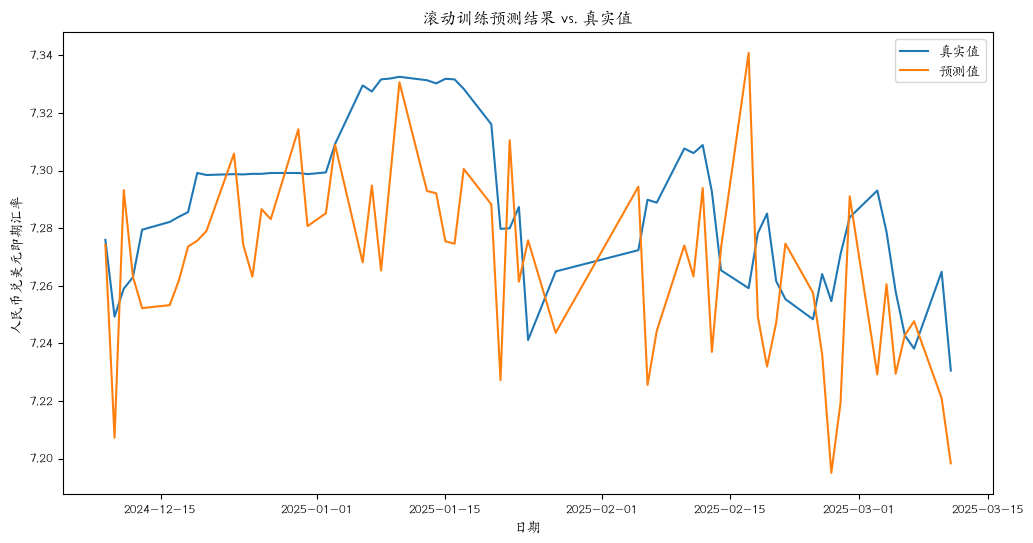

结束： 2025-04-21 12:05:38.498413


In [4]:
# 运行主程序
if __name__ == "__main__":
    main()